# Targets: Using Machine Learning Classification Models to Identify Salient Predictors of Cannabis Arrests in New York City, 2006-2018

# Machine Learning Notebook for Classification Models Part III

This notebook continues the work done in Part I and II, this time focusing on building the best classification model to help differentiate misdemeanor cannabis sales from the four other types of cannabis crime in New York City between 2006-2018: misdemeanor possession, violation possession, felony possession, and felony sales. This notebook continues to explore the line between cannabis possession and sales crimes at a greater level of granularity, while aiming to discover the most salient coefficients of the classification models to uncover the features of the dataset with the strongest relationship to misdemeanor cannabis sales.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.utils import resample

In [2]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1296)

A flow chart of the machine learning pipeline for classifying misdemeanor sales crimes from all other cannabis crimes in New York City between 2006 and 2018 is visualized below. The final outcome of which algorithm performed best is included in this visualization.

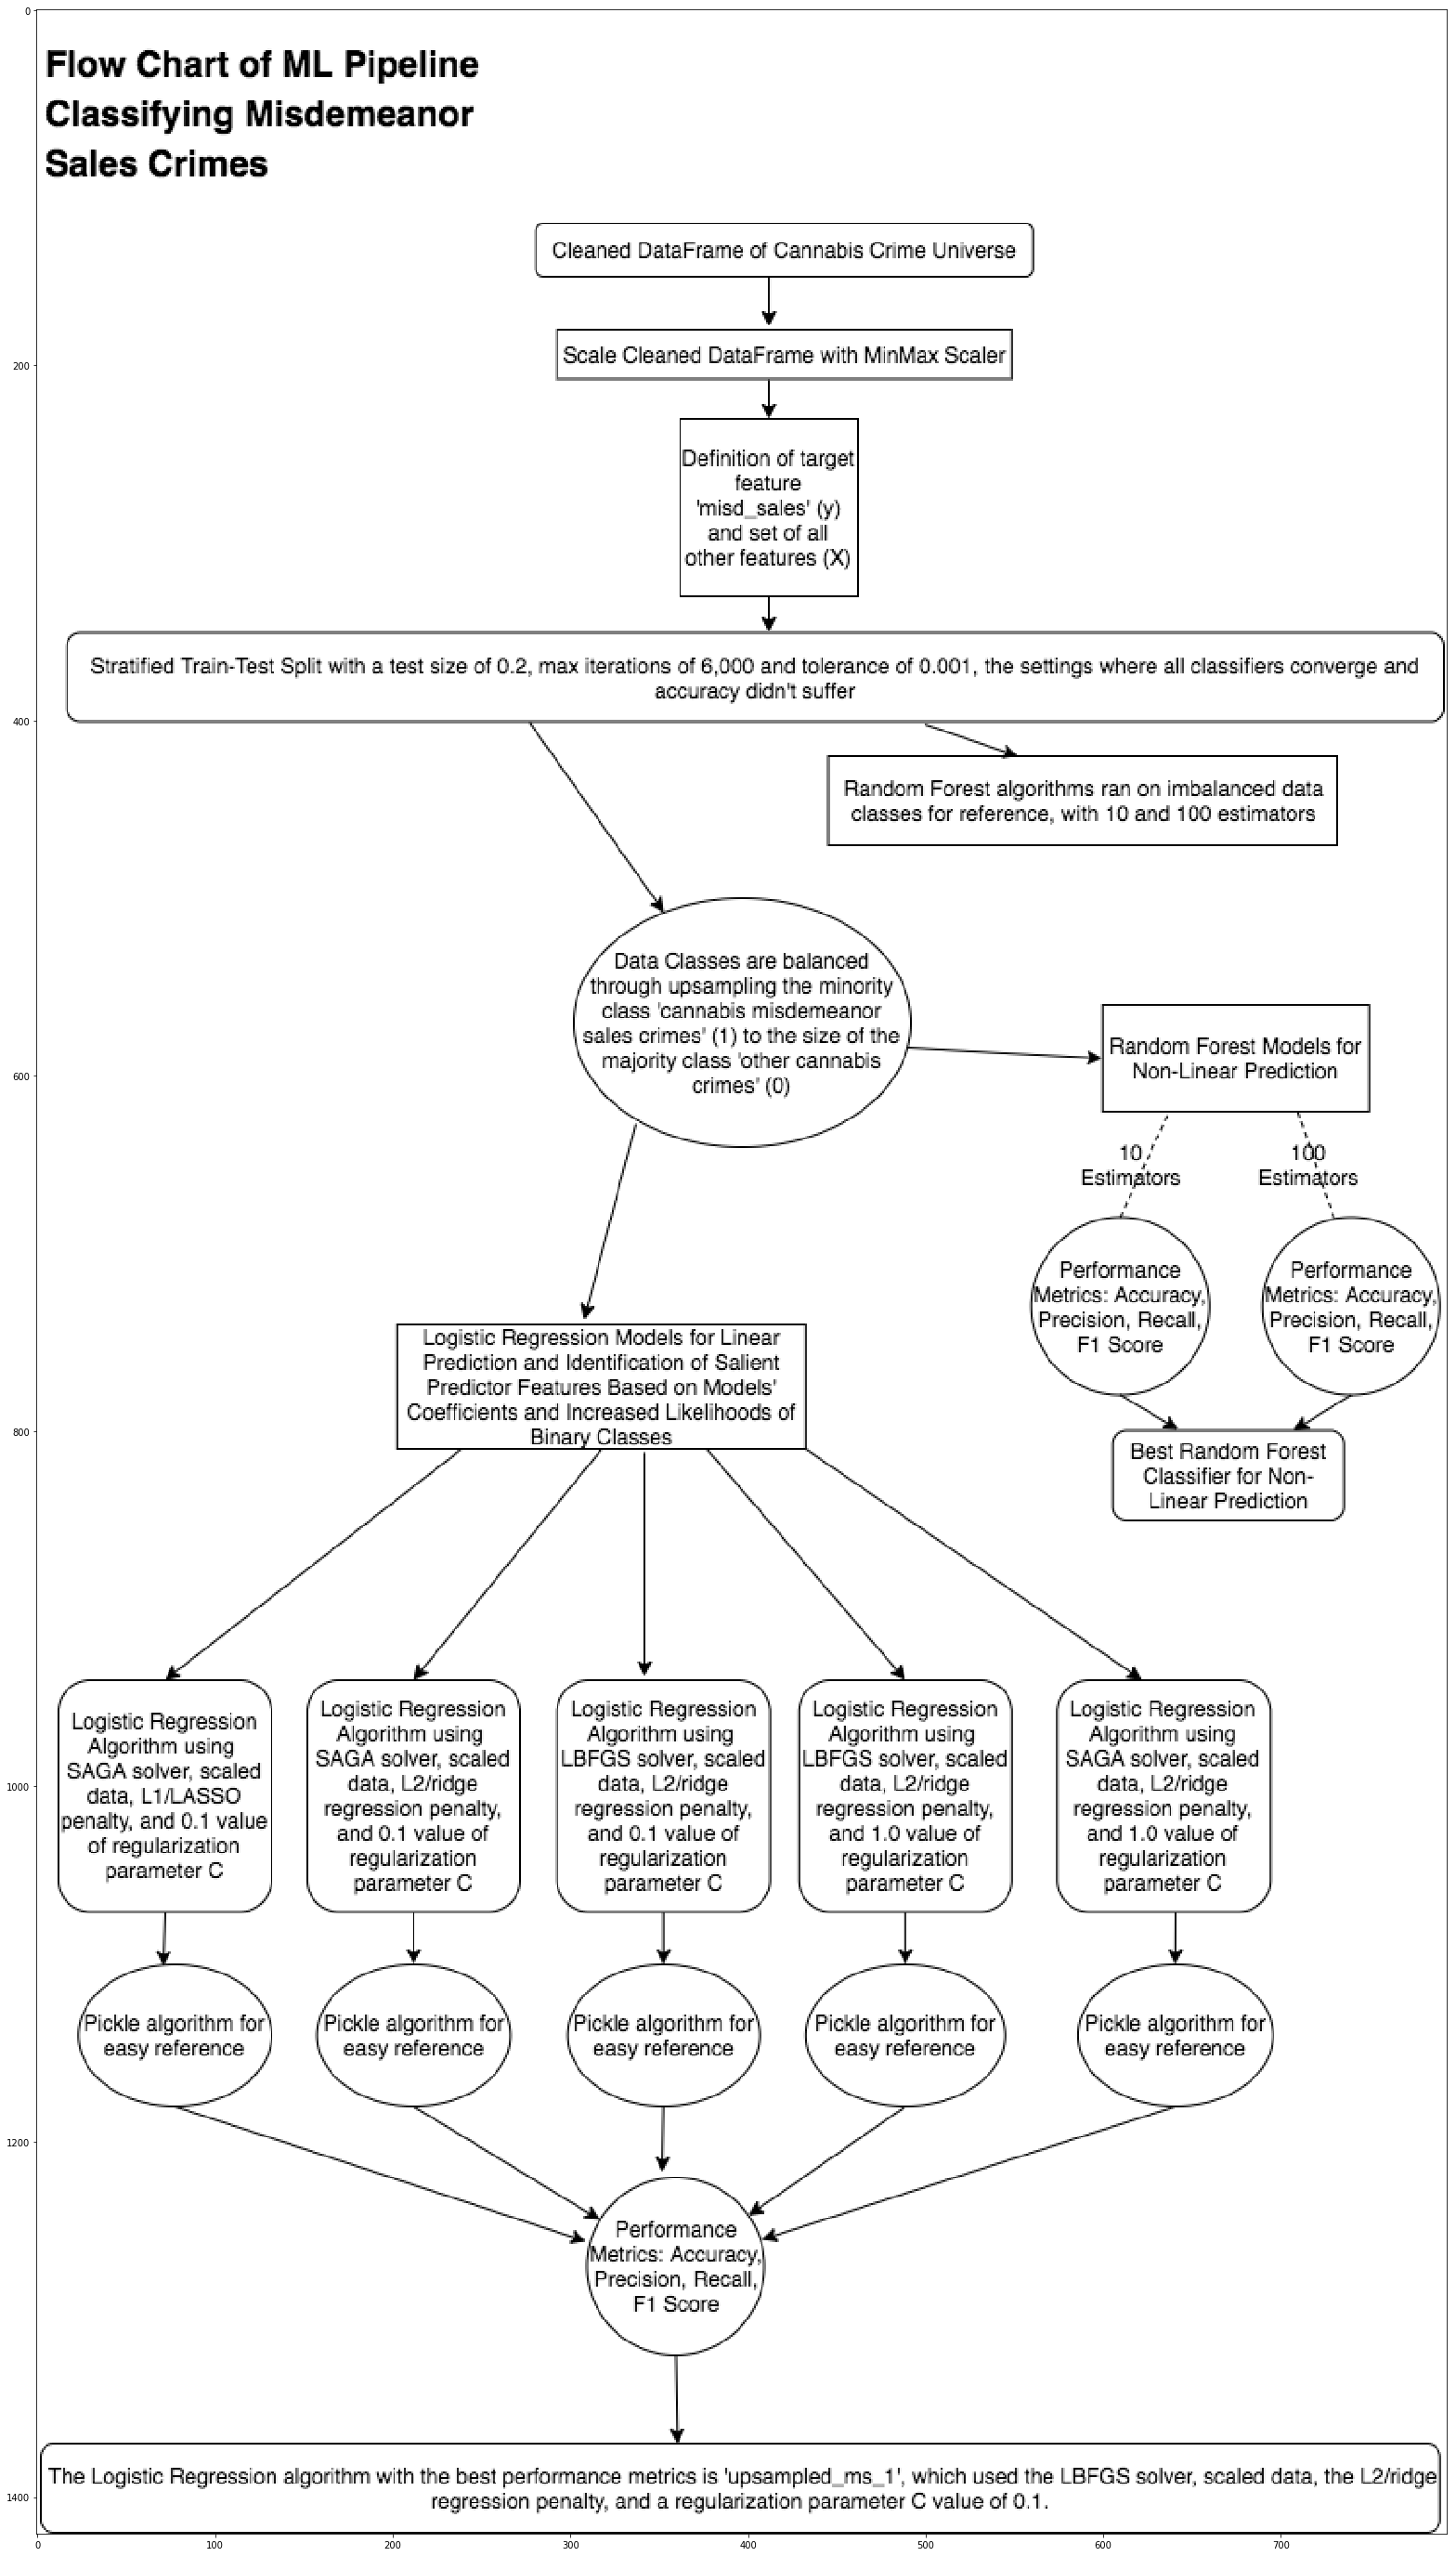

In [3]:
plt.rcParams["figure.figsize"] = (150, 50)
im = plt.imread("Misdemeanor Sales ML Pipeline.png")
implot = plt.imshow(im)

The DataFrame of all 220,304 cannabis crimes is loaded into the 'df' DataFrame, and its shape is called for reference.

In [3]:
df = pd.read_csv('nyc_cann_for_ml.csv', index_col=0)

In [4]:
df.shape

(220304, 1302)

# Misdemeanor Sales Crimes

The misdemeanor sales cases have a value of '1' in the 'misd_sales' feature, and all other cannabis crimes have a value of '0'. Because this round of classification is focused on misdemeanor sales cannabis crimes versus all other cannabis crimes, a series of features that also describe the type of crime must be dropped from the DataFrame in order to avoid leakage. These features are dropped in the next cell, which also creates a subsetted DataFrame for use in classifying misdemeanor sales crimes. 'CMPLNT_NUM' uniquely identifies each crime, so it is also dropped to avoid leakage (as described in the data cleaning notebook for the creation of the cannabis/non-cannabis DataFrame).

In [75]:
df_ms = df.drop(columns = ['CMPLNT_NUM', 'possession', 'misd_poss', 'viol_poss', 'felony_poss', 'felony_sales'])

In [76]:
df_ms['misd_sales'].value_counts()

0    208878
1     11426
Name: misd_sales, dtype: int64

The .head() method is called on the 'df_ms' DataFrame for reference.

In [105]:
df_ms.head()

,Latitude,Longitude,misd_sales,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,closest_subway_distance_l1,closest_subway_distance_l2,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,ADDR_PCT_CD_1.0,ADDR_PCT_CD_5.0,ADDR_PCT_CD_6.0,ADDR_PCT_CD_7.0,ADDR_PCT_CD_9.0,ADDR_PCT_CD_10.0,ADDR_PCT_CD_13.0,ADDR_PCT_CD_14.0,ADDR_PCT_CD_17.0,ADDR_PCT_CD_18.0,ADDR_PCT_CD_19.0,ADDR_PCT_CD_20.0,ADDR_PCT_CD_22.0,ADDR_PCT_CD_23.0,ADDR_PCT_CD_24.0,ADDR_PCT_CD_25.0,ADDR_PCT_CD_26.0,ADDR_PCT_CD_28.0,ADDR_PCT_CD_30.0,ADDR_PCT_CD_32.0,ADDR_PCT_CD_33.0,ADDR_PCT_CD_34.0,ADDR_PCT_CD_40.0,ADDR_PCT_CD_41.0,ADDR_PCT_CD_42.0,ADDR_PCT_CD_43.0,ADDR_PCT_CD_44.0,ADDR_PCT_CD_45.0,ADDR_PCT_CD_46.0,ADDR_PCT_CD_47.0,ADDR_PCT_CD_48.0,ADDR_PCT_CD_49.0,ADDR_PCT_CD_50.0,ADDR_PCT_CD_52.0,ADDR_PCT_CD_60.0,ADDR_PCT_CD_61.0,ADDR_PCT_CD_62.0,ADDR_PCT_CD_63.0,ADDR_PCT_CD_66.0,ADDR_PCT_CD_67.0,ADDR_PCT_CD_68.0,ADDR_PCT_CD_69.0,ADDR_PCT_CD_70.0,ADDR_PCT_CD_71.0,ADDR_PCT_CD_72.0,ADDR_PCT_CD_73.0,ADDR_PCT_CD_75.0,ADDR_PCT_CD_76.0,ADDR_PCT_CD_77.0,ADDR_PCT_CD_78.0,ADDR_PCT_CD_79.0,ADDR_PCT_CD_81.0,ADDR_PCT_CD_83.0,ADDR_PCT_CD_84.0,ADDR_PCT_CD_88.0,ADDR_PCT_CD_90.0,ADDR_PCT_CD_94.0,ADDR_PCT_CD_100.0,ADDR_PCT_CD_101.0,ADDR_PCT_CD_102.0,ADDR_PCT_CD_103.0,ADDR_PCT_CD_104.0,ADDR_PCT_CD_105.0,ADDR_PCT_CD_106.0,ADDR_PCT_CD_107.0,ADDR_PCT_CD_108.0,ADDR_PCT_CD_109.0,ADDR_PCT_CD_110.0,ADDR_PCT_CD_111.0,ADDR_PCT_CD_112.0,ADDR_PCT_CD_113.0,ADDR_PCT_CD_114.0,ADDR_PCT_CD_115.0,ADDR_PCT_CD_120.0,ADDR_PCT_CD_121.0,ADDR_PCT_CD_122.0,ADDR_PCT_CD_123.0,BORO_NM_BRONX,BORO_NM_BROOKLYN,BORO_NM_MANHATTAN,BORO_NM_QUEENS,BORO_NM_STATEN ISLAND,BORO_NM_unknown,LOC_OF_OCCUR_DESC_FRONT OF,LOC_OF_OCCUR_DESC_INSIDE,LOC_OF_OCCUR_DESC_OPPOSITE OF,LOC_OF_OCCUR_DESC_REAR OF,LOC_OF_OCCUR_DESC_unknown,PREM_TYP_DESC_ABANDONED BUILDING,PREM_TYP_DESC_AIRPORT TERMINAL,PREM_TYP_DESC_ATM,PREM_TYP_DESC_BANK,PREM_TYP_DESC_BAR/NIGHT CLUB,PREM_TYP_DESC_BEAUTY & NAIL SALON,PREM_TYP_DESC_BOOK/CARD,PREM_TYP_DESC_BRIDGE,PREM_TYP_DESC_BUS (NYC TRANSIT),PREM_TYP_DESC_BUS (OTHER),PREM_TYP_DESC_BUS STOP,PREM_TYP_DESC_BUS TERMINAL,PREM_TYP_DESC_CANDY STORE,PREM_TYP_DESC_CEMETERY,PREM_TYP_DESC_CHAIN STORE,PREM_TYP_DESC_CHECK CASHING BUSINESS,PREM_TYP_DESC_CHURCH,PREM_TYP_DESC_CLOTHING/BOUTIQUE,PREM_TYP_DESC_COMMERCIAL BUILDING,PREM_TYP_DESC_CONSTRUCTION SITE,PREM_TYP_DESC_DEPARTMENT STORE,PREM_TYP_DESC_DOCTOR/DENTIST OFFICE,PREM_TYP_DESC_DRUG STORE,PREM_TYP_DESC_DRY CLEANER/LAUNDRY,PREM_TYP_DESC_FACTORY/WAREHOUSE,PREM_TYP_DESC_FAST FOOD,PREM_TYP_DESC_FERRY/FERRY TERMINAL,PREM_TYP_DESC_FOOD SUPERMARKET,PREM_TYP_DESC_GAS STATION,PREM_TYP_DESC_GROCERY/BODEGA,PREM_TYP_DESC_GYM/FITNESS FACILITY,PREM_TYP_DESC_HIGHWAY/PARKWAY,PREM_TYP_DESC_HOSPITAL,PREM_TYP_DESC_HOTEL/MOTEL,PREM_TYP_DESC_JEWELRY,PREM_TYP_DESC_LIQUOR STORE,PREM_TYP_DESC_MARINA/PIER,PREM_TYP_DESC_OPEN AREAS (OPEN LOTS),PREM_TYP_DESC_OTHER,PREM_TYP_DESC_OTHER HOUSE OF WORSHIP,PREM_TYP_DESC_PARK/PLAYGROUND,PREM_TYP_DESC_PARKING LOT/GARAGE (PRIVATE),PREM_TYP_DESC_PARKING LOT/GARAGE (PUBLIC),P

## Scaling the DataFrame

We now use MinMaxScaler to normalize the data.

In [77]:
scaler = MinMaxScaler()

In [78]:
scaler.fit(df_ms)

/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [79]:
df_ms_scaled = pd.DataFrame(scaler.transform(df_ms), columns=df_ms.columns, index=df_ms.index)

In [10]:
df_ms_scaled.head()

,Latitude,Longitude,misd_sales,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,closest_subway_distance_l1,closest_subway_distance_l2,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,ADDR_PCT_CD_1.0,ADDR_PCT_CD_5.0,ADDR_PCT_CD_6.0,ADDR_PCT_CD_7.0,ADDR_PCT_CD_9.0,ADDR_PCT_CD_10.0,ADDR_PCT_CD_13.0,ADDR_PCT_CD_14.0,ADDR_PCT_CD_17.0,ADDR_PCT_CD_18.0,ADDR_PCT_CD_19.0,ADDR_PCT_CD_20.0,ADDR_PCT_CD_22.0,ADDR_PCT_CD_23.0,ADDR_PCT_CD_24.0,ADDR_PCT_CD_25.0,ADDR_PCT_CD_26.0,ADDR_PCT_CD_28.0,ADDR_PCT_CD_30.0,ADDR_PCT_CD_32.0,ADDR_PCT_CD_33.0,ADDR_PCT_CD_34.0,ADDR_PCT_CD_40.0,ADDR_PCT_CD_41.0,ADDR_PCT_CD_42.0,ADDR_PCT_CD_43.0,ADDR_PCT_CD_44.0,ADDR_PCT_CD_45.0,ADDR_PCT_CD_46.0,ADDR_PCT_CD_47.0,ADDR_PCT_CD_48.0,ADDR_PCT_CD_49.0,ADDR_PCT_CD_50.0,ADDR_PCT_CD_52.0,ADDR_PCT_CD_60.0,ADDR_PCT_CD_61.0,ADDR_PCT_CD_62.0,ADDR_PCT_CD_63.0,ADDR_PCT_CD_66.0,ADDR_PCT_CD_67.0,ADDR_PCT_CD_68.0,ADDR_PCT_CD_69.0,ADDR_PCT_CD_70.0,ADDR_PCT_CD_71.0,ADDR_PCT_CD_72.0,ADDR_PCT_CD_73.0,ADDR_PCT_CD_75.0,ADDR_PCT_CD_76.0,ADDR_PCT_CD_77.0,ADDR_PCT_CD_78.0,ADDR_PCT_CD_79.0,ADDR_PCT_CD_81.0,ADDR_PCT_CD_83.0,ADDR_PCT_CD_84.0,ADDR_PCT_CD_88.0,ADDR_PCT_CD_90.0,ADDR_PCT_CD_94.0,ADDR_PCT_CD_100.0,ADDR_PCT_CD_101.0,ADDR_PCT_CD_102.0,ADDR_PCT_CD_103.0,ADDR_PCT_CD_104.0,ADDR_PCT_CD_105.0,ADDR_PCT_CD_106.0,ADDR_PCT_CD_107.0,ADDR_PCT_CD_108.0,ADDR_PCT_CD_109.0,ADDR_PCT_CD_110.0,ADDR_PCT_CD_111.0,ADDR_PCT_CD_112.0,ADDR_PCT_CD_113.0,ADDR_PCT_CD_114.0,ADDR_PCT_CD_115.0,ADDR_PCT_CD_120.0,ADDR_PCT_CD_121.0,ADDR_PCT_CD_122.0,ADDR_PCT_CD_123.0,BORO_NM_BRONX,BORO_NM_BROOKLYN,BORO_NM_MANHATTAN,BORO_NM_QUEENS,BORO_NM_STATEN ISLAND,BORO_NM_unknown,LOC_OF_OCCUR_DESC_FRONT OF,LOC_OF_OCCUR_DESC_INSIDE,LOC_OF_OCCUR_DESC_OPPOSITE OF,LOC_OF_OCCUR_DESC_REAR OF,LOC_OF_OCCUR_DESC_unknown,PREM_TYP_DESC_ABANDONED BUILDING,PREM_TYP_DESC_AIRPORT TERMINAL,PREM_TYP_DESC_ATM,PREM_TYP_DESC_BANK,PREM_TYP_DESC_BAR/NIGHT CLUB,PREM_TYP_DESC_BEAUTY & NAIL SALON,PREM_TYP_DESC_BOOK/CARD,PREM_TYP_DESC_BRIDGE,PREM_TYP_DESC_BUS (NYC TRANSIT),PREM_TYP_DESC_BUS (OTHER),PREM_TYP_DESC_BUS STOP,PREM_TYP_DESC_BUS TERMINAL,PREM_TYP_DESC_CANDY STORE,PREM_TYP_DESC_CEMETERY,PREM_TYP_DESC_CHAIN STORE,PREM_TYP_DESC_CHECK CASHING BUSINESS,PREM_TYP_DESC_CHURCH,PREM_TYP_DESC_CLOTHING/BOUTIQUE,PREM_TYP_DESC_COMMERCIAL BUILDING,PREM_TYP_DESC_CONSTRUCTION SITE,PREM_TYP_DESC_DEPARTMENT STORE,PREM_TYP_DESC_DOCTOR/DENTIST OFFICE,PREM_TYP_DESC_DRUG STORE,PREM_TYP_DESC_DRY CLEANER/LAUNDRY,PREM_TYP_DESC_FACTORY/WAREHOUSE,PREM_TYP_DESC_FAST FOOD,PREM_TYP_DESC_FERRY/FERRY TERMINAL,PREM_TYP_DESC_FOOD SUPERMARKET,PREM_TYP_DESC_GAS STATION,PREM_TYP_DESC_GROCERY/BODEGA,PREM_TYP_DESC_GYM/FITNESS FACILITY,PREM_TYP_DESC_HIGHWAY/PARKWAY,PREM_TYP_DESC_HOSPITAL,PREM_TYP_DESC_HOTEL/MOTEL,PREM_TYP_DESC_JEWELRY,PREM_TYP_DESC_LIQUOR STORE,PREM_TYP_DESC_MARINA/PIER,PREM_TYP_DESC_OPEN AREAS (OPEN LOTS),PREM_TYP_DESC_OTHER,PREM_TYP_DESC_OTHER HOUSE OF WORSHIP,PREM_TYP_DESC_PARK/PLAYGROUND,PREM_TYP_DESC_PARKING LOT/GARAGE (PRIVATE),PREM_TYP_DESC_PARKING LOT/GARAGE (PUBLIC),P

The target feature in this series of classifications is the binary feature 'misd_sales', with a value of 1 for misdemeanor sales cannabis crimes and 0 for all other cannabis crimes. The target feature is assigned to y.

In [80]:
y = df_ms_scaled['misd_sales']

The feature set is assigned to X, which includes all features in the 'df_ms_scaled' DataFrame which are not the target.

In [81]:
target_names = ['misd_sales']
X = df_ms_scaled[[cn for cn in df_ms_scaled.columns if cn not in target_names]]

## Training and Test Data Split

In order to find the best model that can generalize to unseen data, the DataFrame is split into training and test sets. 

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Random Forest Algorithm

The Random Forest classifier is carried out on the violation possession crimes below on the original training set as an experiment, first with 10 estimators and then 100.

In [286]:
rfc_ms_1 = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

In [287]:
rfc_ms_pred_1 = rfc_ms_1.predict(X_test)

In [288]:
accuracy_score(y_test, rfc_ms_pred_1)

0.9443044869612582

The confusion matrix shows that there are 41,363 true positives, 2,041 false positives, 413 false negatives, and 244 true negatives.

In [289]:
confusion_matrix(y_test, rfc_ms_pred_1)

array([[41363,   413],
       [ 2041,   244]])

In [290]:
print(classification_report(y_test, rfc_ms_pred_1))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     41776
         1.0       0.37      0.11      0.17      2285

   micro avg       0.94      0.94      0.94     44061
   macro avg       0.66      0.55      0.57     44061
weighted avg       0.92      0.94      0.93     44061



In [291]:
filename = 'rfc_ms_1.sav'
pickle.dump(rfc_ms_1, open(filename, 'wb'))

The accuracy and weighted averages for precision, recall, and F1 score are all quite high, but the model is much worse at predicting misdemeanor sales cannabis crimes than other types of cannabis crimes. This is to be expected with imbalanced data classes to some extent, but makes the case for upsampling the minority class.

In [293]:
rfc_ms_2 = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

In [294]:
rfc_ms_pred_2 = rfc_ms_2.predict(X_test)

In [295]:
accuracy_score(y_test, rfc_ms_pred_2)

0.946120151607998

The confusion matrix shows that there are 41,429 true positives, 2,027 false positives, 347 false negatives, and 258 true negatives.

In [296]:
confusion_matrix(y_test, rfc_ms_pred_2)

array([[41429,   347],
       [ 2027,   258]])

In [297]:
print(classification_report(y_test, rfc_ms_pred_2))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     41776
         1.0       0.43      0.11      0.18      2285

   micro avg       0.95      0.95      0.95     44061
   macro avg       0.69      0.55      0.58     44061
weighted avg       0.93      0.95      0.93     44061



In [298]:
filename = 'rfc_ms_2.sav'
pickle.dump(rfc_ms_2, open(filename, 'wb'))

The RandomForest classifier with 100 estimators does perform better than with 10 estimators.

## Upsampling the Minority Class in the Training Set

First, the training data is concatenated back together.

In [83]:
X = pd.concat([X_train, y_train], axis=1)

Then, the minority and majority classes are separated.

In [84]:
not_misd_sales = X[X.misd_sales == 0]
misd_sales = X[X.misd_sales == 1]

Then, the minority class (i.e., viol_poss) is upsampled.

In [85]:
misd_sales_upsampled = resample(misd_sales,
                          replace=True, # sample with replacement
                          n_samples=len(not_misd_sales), # match number in majority class
                          random_state=27) # reproducible results

Then, the majority and upsampled minority classes are combined.

In [86]:
upsampled_ms = pd.concat([not_misd_sales, misd_sales_upsampled])

The new class counts are checked.

In [87]:
upsampled_ms.misd_sales.value_counts()

1.0    167102
0.0    167102
Name: misd_sales, dtype: int64

The 'y_train' target and 'X_train' feature set are then re-defined.

In [88]:
y_train = upsampled_ms.misd_sales

In [89]:
X_train = upsampled_ms.drop('misd_sales', axis=1)

## Using the Best Performing Algorithms

In order to tune the hyperparameters, the top 5 performing LogisticRegression algorithms from the Part II possession vs. sales classification are run. The numbering scheme from Part II is maintained (with the addition of the suffix '_ms'), for ease of reference.

In [307]:
upsampled_ms_15 = linear_model.LogisticRegression(penalty='l1', C=0.1, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [308]:
upsampled_ms_pred_15 = upsampled_ms_15.predict(X_test)
upsampled_ms_pred_15[0:35]

array([1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1.])

In [309]:
accuracy_score(y_test, upsampled_ms_pred_15)

0.6874106352556683

The confusion matrix shows that there are 28,799 true positives, 796 false positives, 12,977 false negatives, and 1,489 true negatives.

In [310]:
confusion_matrix(y_test, upsampled_ms_pred_15)

array([[28799, 12977],
       [  796,  1489]])

In [311]:
print(classification_report(y_test, upsampled_ms_pred_15))

              precision    recall  f1-score   support

         0.0       0.97      0.69      0.81     41776
         1.0       0.10      0.65      0.18      2285

   micro avg       0.69      0.69      0.69     44061
   macro avg       0.54      0.67      0.49     44061
weighted avg       0.93      0.69      0.77     44061



In [312]:
filename = 'upsampled_ms_15.sav'
pickle.dump(upsampled_ms_15, open(filename, 'wb'))

In [313]:
upsampled_ms_9 = linear_model.LogisticRegression(penalty='l2', C=0.1, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [314]:
upsampled_ms_pred_9 = upsampled_ms_9.predict(X_test)
upsampled_ms_pred_9[0:35]

array([1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1.])

In [315]:
accuracy_score(y_test, upsampled_ms_pred_9)

0.687478722679921

The confusion matrix shows that there are 28,793 true positives, 787 false positives, 12,983 false negatives, and 1,498 true negatives.

In [316]:
confusion_matrix(y_test, upsampled_ms_pred_9)

array([[28793, 12983],
       [  787,  1498]])

In [317]:
print(classification_report(y_test, upsampled_ms_pred_9))

              precision    recall  f1-score   support

         0.0       0.97      0.69      0.81     41776
         1.0       0.10      0.66      0.18      2285

   micro avg       0.69      0.69      0.69     44061
   macro avg       0.54      0.67      0.49     44061
weighted avg       0.93      0.69      0.77     44061



In [318]:
filename = 'upsampled_ms_9.sav'
pickle.dump(upsampled_ms_9, open(filename, 'wb'))

In [90]:
upsampled_ms_1 = linear_model.LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [91]:
upsampled_ms_pred_1 = upsampled_ms_1.predict(X_test)
upsampled_ms_pred_1[0:35]

array([1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1.])

In [113]:
accuracy_score(y_test, upsampled_ms_pred_1)

0.687569505912258

The confusion matrix shows that there are 28,797 true positives, 787 false positives, 12,979 false negatives, and 1,498 true negatives.

In [114]:
confusion_matrix(y_test, upsampled_ms_pred_1)

array([[28797, 12979],
       [  787,  1498]])

In [115]:
print(classification_report(y_test, upsampled_ms_pred_1))

              precision    recall  f1-score   support

         0.0       0.97      0.69      0.81     41776
         1.0       0.10      0.66      0.18      2285

   micro avg       0.69      0.69      0.69     44061
   macro avg       0.54      0.67      0.49     44061
weighted avg       0.93      0.69      0.77     44061



In [324]:
filename = 'upsampled_ms_1.sav'
pickle.dump(upsampled_ms_1, open(filename, 'wb'))

In [325]:
upsampled_ms_4 = linear_model.LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [326]:
upsampled_ms_pred_4 = upsampled_ms_4.predict(X_test)
upsampled_ms_pred_4[0:35]

array([1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1.])

In [327]:
accuracy_score(y_test, upsampled_ms_pred_4)

0.6853226209119175

The confusion matrix shows that there are 28,702 true positives, 791 false positives, 13,074 false negatives, and 1,494 true negatives.

In [328]:
confusion_matrix(y_test, upsampled_ms_pred_4)

array([[28702, 13074],
       [  791,  1494]])

In [329]:
print(classification_report(y_test, upsampled_ms_pred_4))

              precision    recall  f1-score   support

         0.0       0.97      0.69      0.81     41776
         1.0       0.10      0.65      0.18      2285

   micro avg       0.69      0.69      0.69     44061
   macro avg       0.54      0.67      0.49     44061
weighted avg       0.93      0.69      0.77     44061



In [330]:
filename = 'upsampled_ms_4.sav'
pickle.dump(upsampled_ms_4, open(filename, 'wb'))

In [331]:
upsampled_ms_10 = linear_model.LogisticRegression(penalty='l2', C=1.0, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [332]:
upsampled_ms_pred_10 = upsampled_ms_10.predict(X_test)
upsampled_ms_pred_10[0:35]

array([1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1.])

In [333]:
accuracy_score(y_test, upsampled_ms_pred_10)

0.6854360999523388

The confusion matrix shows that there are 28,707 true positives, 791 false positives, 13,069 false negatives, and 1,494 true negatives.

In [334]:
confusion_matrix(y_test, upsampled_ms_pred_10)

array([[28707, 13069],
       [  791,  1494]])

In [335]:
print(classification_report(y_test, upsampled_ms_pred_10))

              precision    recall  f1-score   support

         0.0       0.97      0.69      0.81     41776
         1.0       0.10      0.65      0.18      2285

   micro avg       0.69      0.69      0.69     44061
   macro avg       0.54      0.67      0.49     44061
weighted avg       0.93      0.69      0.77     44061



In [336]:
filename = 'upsampled_ms_10.sav'
pickle.dump(upsampled_ms_10, open(filename, 'wb'))

## Best LogisticRegression Algorithm

The best performing LogisticRegression algorithm is 'upsampled_ms_1', which uses the 'lbfgs' solver, L2 penalty, and a C value of 0.1. This will be used to call the coefficients for the feature set.

## Random Forest Algorithm on Upsampled Training Data

A Random Forest classifier was used on the original training data above, but it is also carried out below on the upsampled training data out of experimental interest. First, 10 estimators, and then 100 estimators are tried.

In [337]:
rfc_ms_3 = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

In [338]:
rfc_ms_pred_3 = rfc_ms_3.predict(X_test)
rfc_ms_pred_3[0:35]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [339]:
accuracy_score(y_test, rfc_ms_pred_3)

0.9355439050407389

The confusion matrix shows that there are 40,825 true positives, 1,889 false positives, 951 false negatives, and 396 true negatives.

In [340]:
confusion_matrix(y_test, rfc_ms_pred_3)

array([[40825,   951],
       [ 1889,   396]])

In [341]:
print(classification_report(y_test, rfc_ms_pred_3))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     41776
         1.0       0.29      0.17      0.22      2285

   micro avg       0.94      0.94      0.94     44061
   macro avg       0.62      0.58      0.59     44061
weighted avg       0.92      0.94      0.93     44061



In [342]:
filename = 'misd_sales_rfc_3.sav'
pickle.dump(rfc_ms_3, open(filename, 'wb'))

In [343]:
rfc_ms_4 = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

In [344]:
rfc_ms_pred_4 = rfc_ms_4.predict(X_test)
rfc_ms_pred_4[0:35]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [345]:
accuracy_score(y_test, rfc_ms_pred_4)

0.9360659086266766

The confusion matrix shows that there are 40,846 true positives, 1,887 false positives, 930 false negatives, and 398 true negatives.

In [346]:
confusion_matrix(y_test, rfc_ms_pred_4)

array([[40846,   930],
       [ 1887,   398]])

In [347]:
print(classification_report(y_test, rfc_ms_pred_4))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     41776
         1.0       0.30      0.17      0.22      2285

   micro avg       0.94      0.94      0.94     44061
   macro avg       0.63      0.58      0.59     44061
weighted avg       0.92      0.94      0.93     44061



In [348]:
filename = 'misd_sales_rfc_4.sav'
pickle.dump(rfc_ms_4, open(filename, 'wb'))

## Best Performing Classification Algorithm for Cannabis Misdemeanor Sales Crimes

The best performing classification algorithm is the Random Forest algorithm with 100 estimators. The only metric where it is far lower than the 'upsampled_ms_1' LogisticRegression algorithm is recall (or true positive rate) for misdemeanor sales crimes (0.17 vs. 0.66). The Random Forest algorithm with 100 estimators performs the best, but the 'upsampled_ms_1' LogisticRegression algorithm will still be used to call the coefficients for the feature set as RandomForest is incapable of doing so, and these coefficients will help highlight the most salient features that differentiate cannabis misdemeanor sales crimes from all other cannabis crimes. The hyperparameter tuning table for misdemeanor cannabis sales crimes and all other cannabis crimes is shown below, for reference.

In [116]:
misd_sales_metrics = pd.read_excel('HP tuning table.xlsx', sheet_name='Misd_Sales')
misd_sales_metrics

,UPSAMPLED,LR_#,Accuracy_Score,Precision_Not_Misd_Sales,Precision_Misd_Sales,Precision_Wtd_Average,Recall_Not_Misd_Sales,Recall_Misd_Sales,Recall_Wtd_Average,F1_Score_Not_Misd_Sales,F1_Score_Misd_Sales,F1_Score_Wtd_Average,Support_Not_Viol_Poss,Support_Viol_Poss,Support_Total
0,"RF, scaled, 100 n_estimators",rfc_ms_pred_4,0.936066,0.96,0.30,0.92,0.98,0.17,0.94,0.97,0.22,0.93,41776.0,2285.0,44061.0
1,"RF, scaled, 10 n_estimators",rfc_ms_pred_3,0.935544,0.96,0.29,0.92,0.98,0.17,0.94,0.97,0.22,0.93,41776.0,2285.0,44061.0
2,"LR, scaled, lbfgs solver, L2 penalty, C=0.1",upsampled_ms_1,0.687570,0.97,0.10,0.93,0.69,0.66,0.69,0.81,0.18,0.77,41776.0,2285.0,44061.0
3,"LR, scaled, saga solver, L2 penalty, C=0.1",upsampled_ms_9,0.687479,0.97,0.10,0.93,0.69,0.66,0.69,0.81,0.18,0.77,41776.0,2285.0,44061.0
4,"LR, scaled, saga solver, L1 penalty, C=0.1",upsampled_ms_15,0.687411,0.97,0.10,0.93,0.69,0.65,0.69,0.81,0.18,0.77,41776.0,2285.0,44061.0
5,"LR, scaled, saga solver, L2 penalty, C=1.0",upsampled_ms_10,0.685436,0.97,0.10,0.93,0.69,0.65,0.69,0.81,0.18,0.77,41776.0,2285.0,44061.0
6,"LR, scaled, lbfgs solver, L2 penalty, C=1.0",upsampled_ms_4,0.685323,0.97,0.10,0.93,0.69,0.65,0.69,0.81,0.18,0.77,41776.0,2285.0,44061.0
7,IMBALANCED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,"RandomForest, 10 estimators",rfc_ms1,0.944304,0.95,0.37,0.92,0.99,0.11,0.94,0.97,0.17,0.93,41776.0,2285.0,44061.0
9,"RandomForest, 100 estimators",rfc_ms2,0.946120,0.95,0.43,0.93,0.99,0.11,0.95,0.97,0.18,0.93,41776.0,2285.0,44061.0


## ROC curve and AUC

The best Receiver Operating Characteristic (ROC) curve and Area Under the Curve (AUC) are called on both the Random Forest algorithm with 100 estimators, and on the 'upsampled_ms_1' LogisticRegression algorithm. This is done to further evaluate the model.

In [350]:
y_pred_prob_rfc_ms_4 = rfc_ms_4.predict_proba(X_test)[:,1]
y_pred_prob_rfc_ms_4

array([0.  , 0.16, 0.08, ..., 0.04, 0.02, 0.  ])

In [351]:
fpr_rfc_ms_4, tpr_rfc_ms_4, thresholds_rfc_ms_4 = roc_curve(y_test, y_pred_prob_rfc_ms_4)

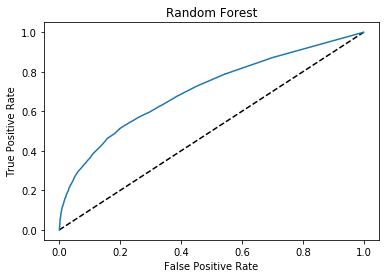

In [352]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rfc_ms_4, tpr_rfc_ms_4, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest')
plt.show();

In [353]:
auc_score_rfc_ms_4 = roc_auc_score(y_test, y_pred_prob_rfc_ms_4)
auc_score_rfc_ms_4

0.7059385651263339

In [118]:
y_pred_prob_upsampled_ms_1 = upsampled_ms_1.predict_proba(X_test)[:,1]
y_pred_prob_upsampled_ms_1

array([0.65323214, 0.68625827, 0.53902168, ..., 0.71397259, 0.41471236,
       0.40460776])

In [119]:
fpr_upsampled_ms_1, tpr_upsampled_ms_1, thresholds_upsampled_ms_1 = roc_curve(y_test, y_pred_prob_upsampled_ms_1)

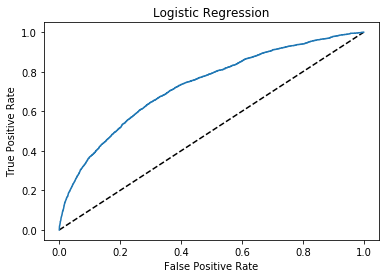

In [120]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_upsampled_ms_1, tpr_upsampled_ms_1, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression')
plt.show();

In [121]:
auc_score_upsampled_ms_1 = roc_auc_score(y_test, y_pred_prob_upsampled_ms_1)
auc_score_upsampled_ms_1

0.7297611697103735

The 'upsampled_ms_1' LogisticRegression algorithm has a slightly higher AUC score than the Random Forest classifier with 100 estimators.

## Precision Recall Curve

Because of the imbalanced class count, the 1st LogisticRegression algorithm is evaluated below with a Precision-Recall Curve.

The precision recall curve is defined below, as is the F1 score and AUC for the precision-recall curve.

In [122]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_prob_upsampled_ms_1)

In [123]:
lr_ms_f1, lr_ms_auc = f1_score(y_test, upsampled_ms_pred_1), auc(lr_recall, lr_precision)

The scores are then summarized.

In [124]:
print('Logistic: f1=%.3f auc=%.3f' % (lr_ms_f1, lr_ms_auc))

Logistic: f1=0.179 auc=0.166


The precision-recall curve is then plotted for the best Logistic Regression algorithm. The precision-recall curve's AUC is very low, showing that the model does not have a good harmonic average of precision and recall for misdemeanor sales crimes but is moderately skillful at predicting other cannabis crimes as a group.

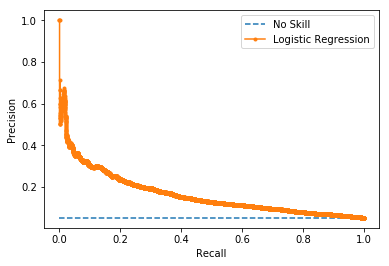

In [125]:
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Evaluation of the Classification Models for Misdemeanor Sales

The best LogisticRegression model ('upsampled_ms_1') has an accuracy of 0.687569505912258, showing that it makes correct predictions on roughly 68.8% of the data points in the DataFrame.

The model's precision is 0.10 for the misdemeanor sales class (the 1 class), 0.97 for the other cannabis crime types class (the 0 class), and 0.93 on weighted average, showing that 10% of predicted misdemeanor sales crimes are actual misdemeanor sales crimes, 97% of predicted other cannabis crimes are actual other cannabis crimes, and 93% of crimes on weighted average are predicted correctly. 

The model's recall is 0.66 for the misdemeanor sales class (the 1 class), 0.69 for the other cannabis crime types class (0), and 0.69 on weighted average, showing that 66% of actual misdemeanor sales crimes are predicted as misdemeanor sales crimes, 69% of actual other cannabis crimes are predicted as other cannabis crimes, and that 69% of crimes on weighted average are predicted correctly.

The model's F1 score, or harmonic mean of precision and recall, is 0.18 for the misdemeanor sales class, 0.81 for the other cannabis crimes class, and 0.77 on weighted average. This metric is more informative than precision or recall alone, and shows that only 18% of misdemeanor sales crimes and 81% of other cannabis crimes are being predicted correctly, for a weighted average of 77%.

The ROC curves plotted above show that the best LogisticRegression model ('upsampled_ms_1') has an ROC AUC score of 72.9%, showing that it is a moderately skillful model in predicting misdemeanor sales crimes at a rate higher than random. The Precision Recall Curve has an AUC score of 11.6%. The very low Precision Recall AUC score shows that the model is not very skilled at differentiating true positives from false positives and false negatives for the misdemeanor sales class. However, as is shown above, it is more skillful at predicting the other cannabis crime types as a group. 

The RandomForest model with 100 estimators has an accuracy of 0.7059385651263339. It has a 0.30 precision score for the misdemeanor sales class, a 0.96 precision score for the other crime types class, and a weighted average precision score of 0.92. The model has a recall score of 0.17 for the misdemeanor sales class, a 0.98 recall score for the other crime types class, and a weighted average recall score of 0.94. It has a 0.22 F1 score for the misdemeanor sales class, a 0.97 F1 score for the other crime types class, and a weighted average F1 score of 0.93. The ROC curve plotted above shows that it has an AUC score of 70.6%. This is an unskillful model at predicting misdemeanor sales crimes. 

## Coefficients for Misdemeanor Sales

As detailed above, the F1 score for the misdemeanor sales class is only 0.18 when using the best performing Logistic Regression algorithm 'upsampled_ms_1'. However, the coefficients can still be valuable in identifying salient features of misdemeanor sales crimes to a certain degree if the F1 score is higher than zero. The only scenario where the coefficients would definitely not be valuable is if the algorithm only or almost only predicts one class. To check on whether the algorithm predicts both classes, and not just one, the predicted values 'upsampled_ms_pred_1' are converted to a Pandas Series and then its value counts are called. As can be seen, the misdemeanor sales class is predicted 14,477 times and the other cannabis crime types as a group are predicted 29,584 times. Therefore, the coefficients for the misdemeanor sales class are valuable and are called and analyzed below.

In [23]:
upsampled_ms_pred_1_s = pd.Series(upsampled_ms_pred_1)
upsampled_ms_pred_1_s.value_counts()

0.0    29584
1.0    14477
dtype: int64

In order to look at the most salient predictors of cannabis misdemeanor sales crimes in New York City between 2006-2018, the feature set's coefficients for the best performing Logistic Regression algorithm ('upsampled_ms_1') are identified to find the most predictive features differentiating cannabis misdemeanor sales crimes from all other cannabis crimes.

First, the coefficients are called for all the features in the feature set, assigned to 'best_cf_ms_coeffs' (short for 'best classifier's coefficients').

In [92]:
best_cf_ms_coeffs = pd.Series(upsampled_ms_1.coef_[0], index=X_train.columns) 
best_cf_ms_coeffs

Latitude                                                                        0.162710
Longitude                                                                      -0.359091
duration_days                                                                  -0.337425
start_year                                                                     -0.705237
start_month                                                                     0.071107
start_day                                                                      -0.001944
start_hour                                                                     -0.044675
start_minute                                                                   -0.161284
start_seconds                                                                   0.000000
rpt_cmplnt_dt_match                                                            -0.408681
day_tw                                                                          0.257195
night_tw             

The features' coefficients are then sorted to show the features most predictive of cannabis misdemeanor sales crimes. The features with positive coefficients are more predictive of misdemeanor sales crimes, while the features with negative coefficients are more predictive of all other cannabis crimes. Because the '0' class, i.e. "all other cannabis crimes", is non-differentiated, there is no real value to the negative coefficients and they will be ignored.

In [93]:
sorted_best_cf_ms_coeffs = best_cf_ms_coeffs.sort_values()
sorted_best_cf_ms_coeffs

PREM_TYP_DESC_AIRPORT TERMINAL                                                 -2.417338
HADEVELOPT_SAINT MARY'S PARK                                                   -1.814403
ADDR_PCT_CD_100.0                                                              -1.456032
PREM_TYP_DESC_MARINA/PIER                                                      -1.413512
PREM_TYP_DESC_TAXI (LIVERY LICENSED)                                           -1.358064
HADEVELOPT_MCKINLEY                                                            -1.227779
HADEVELOPT_MORRISANIA AIR RIGHTS 42                                            -1.219047
PATROL_BORO_PATROL BORO BKLYN SOUTH                                            -1.176929
STATION_NAME_42 ST.-PORT AUTHORITY BUS TERM                                    -1.124822
HADEVELOPT_MILL BROOK                                                          -1.102192
PREM_TYP_DESC_HIGHWAY/PARKWAY                                                  -1.095873
JURIS_DESC_TRI-BORO B

To look at which features have the strongest relationship to misdemeanor sales, the features that have at least a 0.703962 coefficient are called and speculated on below by assigning the object 'sorted_best_cf_ms_coeffs'. When exponentiated by assigning the object 'cannabis_ms_coeffs_lls', these features are shown to provide at least a 2% increase in the odds of a crime being a misdemeanor sales crime.

In [94]:
cannabis_ms_coeffs = sorted_best_cf_ms_coeffs[-86:].sort_values(ascending=False)
cannabis_ms_coeffs

PARKS_NM_WASHINGTON SQUARE PARK                       2.761788
STATION_NAME_JACKSON AVENUE                           2.407347
PREM_TYP_DESC_GROCERY/BODEGA                          1.890743
PARKS_NM_STORY PLAYGROUND                             1.868256
HADEVELOPT_WALD                                       1.768317
PARKS_NM_PARKSIDE PLAYGROUND BROOKLYN                 1.764874
SUSP_AGE_GROUP_cleaned_unknown                        1.722372
STATION_NAME_8 AVENUE                                 1.679041
ADDR_PCT_CD_6.0                                       1.539331
STATION_NAME_KINGSTON AVENUE                          1.525441
yankee_stad_l1                                        1.521172
HADEVELOPT_CLAREMONT REHAB (GROUP 3)                  1.507041
PREM_TYP_DESC_LIQUOR STORE                            1.486071
HADEVELOPT_GRANT                                      1.470835
PREM_TYP_DESC_FAST FOOD                               1.470690
STATION_NAME_PENNSYLVANIA AVENUE                      1

In [28]:
cannabis_ms_coeffs_lls = np.array(np.exp(cannabis_ms_coeffs))
cannabis_ms_coeffs_lls

array([15.82811843, 11.10445655,  6.62429146,  6.47699212,  5.8609823 ,
        5.84083554,  5.5977933 ,  5.36041085,  4.66146913,  4.59717193,
        4.5775887 ,  4.51335658,  4.41969667,  4.35287031,  4.35223605,
        4.18869314,  4.12234366,  4.05503828,  4.02717604,  3.87481778,
        3.76617321,  3.68630366,  3.64401571,  3.62963184,  3.52867264,
        3.48638179,  3.39770704,  3.37748658,  3.37417942,  3.35357993,
        3.31500056,  3.22109663,  3.19852306,  3.18666642,  3.17007347,
        3.15231648,  3.06713036,  3.05311598,  2.89614065,  2.89352557,
        2.86344141,  2.85654415,  2.85079043,  2.82533325,  2.80261259,
        2.76596849,  2.75415872,  2.70666344,  2.70442015,  2.69685368,
        2.69472191,  2.69149011,  2.68751324,  2.63614638,  2.56387456,
        2.50989571,  2.46282255,  2.42245919,  2.38841161,  2.33121156,
        2.32391968,  2.30726369,  2.30553149,  2.30530921,  2.26524229,
        2.26113072,  2.24918147,  2.24437867,  2.24234798,  2.23

## Feature Set Coefficients and Likelihoods

The features, their coefficients, and the increased likelihood towards misdemeanor sales crime are called in an Excel table below.

In [29]:
ms_coeffs_lls_table = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='ms_coeffs')
ms_coeffs_lls_table

,Feature,Coefficient,Increased Odds Towards Misdemeanor Sales Class
0,PARKS_NM_WASHINGTON SQUARE PARK,2.761788,15.828118
1,STATION_NAME_JACKSON AVENUE,2.407347,11.104457
2,PREM_TYP_DESC_GROCERY/BODEGA,1.890743,6.624291
3,PARKS_NM_STORY PLAYGROUND,1.868256,6.476992
4,HADEVELOPT_WALD,1.768317,5.860982
5,PARKS_NM_PARKSIDE PLAYGROUND BROOKLYN,1.764874,5.840836
6,SUSP_AGE_GROUP_cleaned_unknown,1.722372,5.597793
7,STATION_NAME_8 AVENUE,1.679041,5.360411
8,ADDR_PCT_CD_6.0,1.539331,4.661469
9,STATION_NAME_KINGSTON AVENUE,1.525441,4.597172


The specific premises features with the highest coefficients show that misdemeanor sales arrests have the strongest relationship with groceries and bodegas, liquor stores, fast food restaurants, candy stores, unclassified stores, gas stations, bars and night clubs, department stores, book and greeting card stores, and variety stores. The increased likelihood of a cannabis crime being a felony possession crime for these features range from 2% to 6%. 

Unlike cannabis possession arrests generally and felony possession arrests, misdemeanor sales arrests have several strong relationships with specific NYC parks. These include in descending order of increased likelihood that a cannabis crime is a misdemeanor sales crimes:

 - Washington Square Park next to the NYU campus (with an increased odds of 15.8%), 
 
 - Story Playground in the Soundview neighborhood of the east Bronx (6.5% increase), 
 
 - Parkside Playground Brooklyn in the Prospect Lefferts Gardens neighborhood of central Brooklyn (5.8% increase), 
 
 - Matthews-Palmer Playground in the Hell's Kitchen neighborhood of Manhattan (3.6% increase),  
 
 - Powell Playground in the Crown Heights neighborhood of central Brooklyn (3.5% increase), 
 
 - St. James Park in the Fordham Manor neighborhood of central Bronx (3.4% increase), 
 
 - Gorman Playground in the Jackson Heights neighborhood of central Queens (2.9% increase), 
 
 - Harlem Art Park in East Harlem (2.9% increase), 
 
 - Maria Hernandez Park in the Bushwick neighborhood of north Brooklyn (2.9% increase), 
 
 - Park of the Americas in the Corona neighborhood of central Queens (2.8% increase),
 
 - Shore Park and Parkway in the Bay Ridge neighborhood of southern Brooklyn (2.8% increase), 
 
 - Frank D. O'Connor Playground in the Elmhurst neighborhood of central Queens (2.3% increase), 
 
 - Unnamed Park on Summit Avenue (unclear location) (2.2% increase), 
 
 - Cooper Park in the East Williamsburg neighborhood of northern Brooklyn (2.2% increase),
 
 - Corona Golf Playground in the Corona neighborhood of central Queens (2.1% increase), 
 
 - L/Cpl Thomas P. Noonan Jr. Playground in the Sunnyside neighborhood of central Queens (2.1% increase), and 
 
 - Harris Park in the Kingsbridge neighborhood of the central Bronx (2.1% increase)

Misdemeanor sales arrests have several strong relationships with specific subway/transit stations. These include (in descending order of coefficients and likelihoods):

- Jackson Avenue in the South Bronx (with an increased odds of 11.1%), 

- 8th Avenue in the Chelsea neighborhood of southern Manhattan (increased odds of 5.36%), 

- Kingston Avenue in the Crown Heights neighborhood of Central Brooklyn (4.6% increase), 

- Pennsylvania Avenue in the East New York neighborhood of eastern Brooklyn (4.2% increase),, 

- Lexington Ave either near Grand Central Station in Midtown Manhattan or in East Harlem as the data label is not specific enough (4.1% increase),  

- Smith-9th Streets in the Carroll Gardens neighborhood of southern Brooklyn (3.2% increase), 

- 7th Avenue in Midtown Manhattan (3.2% increase), 

- Beach 60th Street in Rockaway Beach (3.1% increase), 

- 50th Street which could be the station near the Port Authority bus terminal or a station in the Bay Ridge neighborhood of southern Brooklyn (more likely the former) (2.8% increase), 

- 219th Street in the Baychester neighborhood of the north Bronx (2.7% increase), 

- 155th Street in West Harlem (2.5% increase), 

- Parsons/Archer-Jamaica Center in the Jamaica neighborhood of eastern Queens (2.5% increase), 

- Halsey Street in the Bushwick neighborhood of northern Brooklyn (2.3% increase), 

- 137th St.-City College in West Harlem (2.2% increase), 

- 241st St.-Wakefield in the Northern Bronx (2.2% increase), 

- 34th St.-Herald Sq. in midtown Manhattan (2.1% increase), 

- 42nd St.-Times Square in midtown Manhattan (2% increase)

Unknown or unrecorded suspect age has a 5.6% increased odds that the cannabis crime is a misdemeanor sales crime, showing that there is some underlying reason why the suspect's age is not being recorded for misdemeanor sales crimes.

Cannabis arrests with males are 2.2% more likely to be misdemeanor sales arrests than all other cannabis arrests. This shows that men are more likely to engage in misdemeanor cannabis sales.  The causal reason can't be identified with this analysis.

For each full latitude/longitude unit closer a cannabis crime is to Yankee Stadium in the Bronx in L1 terms, there is a 4.6% increased odds that a cannabis arrest is a misdemeanor sales arrest. 

Police precincts with the highest relationship to misdemeanor sales crime, in descending order, are the 6th, 13th, 33rd, 83rd, 34th, and 112th. Precinct descriptions come from https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page. These cover the following areas:

- 6th - Southwestern Manhattan neighborhoods of Greenwich Village and the West Village (4.7% increase), a liberal enclave housing most of the NYU campus and traditionally a bastion of the counterculture

- 13th - Southern portion of Midtown, Manhattan. The precinct features the Peter Cooper Village/Stuyvesant Town residential complex, Gramercy Park, the lower portion of Rosehill, Madison Square Park, and Union Square Park (3.5% increase). Union Square Park may be responsible for this relationship.

- 33rd - Washington Heights neighborhood of Northern Manhattan (3.4% increase), a traditionally Hispanic neighborhood

- 83rd - Northern region in Brooklyn comprising Bushwick (3.4% increase), a traditionally Hispanic neighborhood

- 34th - Communities of Washington Heights and Inwood, north of West 179th Street (2.6% increase), a traditionally Hispanic neighborhood

- 112th - Centrally located portion of Queens, housing Forest Hills and Rego Park, reflecting the strong relationship between the Pomonok Houses project in this portion of Queens (2.1% increase)

The jurisdictions with the strongest relationship to misdemeanor sales arrests are not the NYPD but the Staten Island Rapid Transit Authority, with an increased likelihood of their cannabis arrests being misdemeanor sales arrests of 2.3%.

The patrol borough with the strongest relationship to misdemeanor sales arrests is the Manhattan North patrol borough, with an increased likelihood of 2.9%.

There are many public housing developments (or projects) that have a strong relationship with misdemeanor sales crimes, again highlighting that public housing developments are home to many cannabis arrests. These include:

- Wald in the Alphabet City neighborhood of Lower Manhattan (5.9% increase),

- Claremont Rehab (Group 3) in the Morrisania neighborhood of the South Bronx (4.5% increase), 

- Grant in the Manhattanville neighborhood of Harlem (4.4% increase), 

- Randall Avenue-Balcom Avenue (4.1% increase)

- Castle Hill in the Castle Hill neighborhood of the South Bronx (3.9% increase),

- Pomonok Houses in the Pomonok neighborhood of Queens (3.8% increase), 

- Bay View in the East New York neighborhood of Brooklyn (3.7% increase), 

- Astoria in the Astoria neighborhood of Queens (3.6% increase), 

- Bland in the Willets neighborhood of eastern Queens (3.3% increase),

- Jacob Riis in the Alphabet City neighborhood of Lower Manhattan (3.2% increase),

- Glenwood in the East Flatbush neighborhood of central Brooklyn (3.2% increase),

- Boynton Avenue Rehab in the Soundview neighborhood of the South Bronx (3.1% increase),

- Sedgwick in the Morris Heights neighborhood of the South Bronx (2.7% increase),

- Queensbridge South between the Astoria and Hunters Point neighborhoods of Queens (2.7% increase), 

- Soundview in the Soundview neighborhood of the South Bronx (2.7% increase), 

- Baruch Houses Addition in the Lower East Side neighborhood of southern Manhattan (2.7% increase),

- Throggs Neck in the Throggs Neck neighborhood of the Bronx, which was shown to have a large percentage of cannabis arrests in the Data Story and EDA notebook (2.7% increase),

- Boston Secor in the Eastchester neighborhood of the north Bronx (2.6% increase),

- Crown Heights in the Weeksville neighborhood near Crown Heights in central Brooklyn (2.4% increase),

- Low Houses in the Brownsville neighborhood of eastern Brooklyn (2.4% increase),

- Vladeck II in the Lower East Side of Manhattan (2.3% increase),

- Farragut in the Vinegar Hill neighborhood just north of downtown Brooklyn (2.3% increase),

- Sterling Place Rehab (Sterling-Buffalo) in the Weeksville neighborhood of Central Brooklyn close to Crown Heights (2.3% increase),

- Sutter Avenue-Union Street in the Brownsville neighborhood of eastern Brooklyn (2.3% increase),

- Union Avenue-East 166th Street in the Forest House neighborhood of the South Bronx (2.3% increase), 

- Breukelen in the Canarsie neighborhood of eastern Brooklyn (2.2% increase),

- La Guardia in the Lower East side of southern Manhattan (2.2% increase),

- Amsterdam on the Upper West Side of Manhattan (2.2% increase),

- Manhattanville in the Manhattanville neighborhood of West Harlem (2.1% increase),

- Ingersoll in downtown Brooklyn (2% increase)

## Relationship of 'Feature Families' to Crime: Misdemeanor Sales and Other Cannabis Crime Types

Because there are so many binarized features in the feature set, the interpretability of these features' coefficients and increased odds towards misdemeanor sales is better enabled by grouping the features into "feature families" (e.g. suspect race, borough, housing development). This grouping strategy involves taking the absolute value sum of all coefficients in the feature set, then summing the absolute values of the coefficients for each "feature family", and then dividing the absolute value coefficient sum of each "feature family" by the total absolute value coefficient sum to uncover the proportion of the total predictive value that each "feature family" has. This will help elucidate the "feature families" that have the strongest predictive power on whether a crime is a misdemeanor sales crime or another type of cannabis crime, and therefore which feature families should be explored further as having the strongest relationship to misdemeanor sales.

A summary table of the sum of all coefficients, the sum of coefficients for each feature family, and the proportion of the total sum of all coefficients that each feature family has is called below. Any family with more than 10 percent of the total coefficient sum will be examined further. That includes housing developments, transit stations, NYC parks, premises types and police precincts. Because suspect race is a main concern of arrest biases when it comes to cannabis crime, it is also examined.

In [114]:
proportions_table_ms = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='ms_family_props')
proportions_table_ms

,Feature Family,Sum of Coeffs,Proportion of Total Coeffs,Unnamed: 3
0,"Sum of all coeffs, absolute value",NaN,NaN,334.066875
1,Housing Developments,112.419852,0.336519,NaN
2,Transit Stations,51.648664,0.154606,NaN
3,NYC Parks,47.097872,0.140983,NaN
4,Premises Types,35.228099,0.105452,NaN
5,Police Precincts,33.979612,0.101715,NaN
6,L1 Distances from NYC Landmarks,9.985239,0.029890,NaN
7,L2 Distances from NYC Landmarks,6.665353,0.019952,NaN
8,Jurisdictions of Crime,6.661724,0.019941,NaN
9,Transit Districts,5.245262,0.015701,NaN


In [96]:
sum_of_all_coeffs_ms = np.sum(abs(sorted_best_cf_ms_coeffs.values))
sum_of_all_coeffs_ms

334.06687505601485

In [97]:
is_race_coeffs_ms = []
for name in sorted_best_cf_ms_coeffs.index.values:
    is_race_coeffs_ms.append(name.startswith('SUSP_RACE_'))
is_race_coeffs_ms = np.array(is_race_coeffs_ms)

In [98]:
race_coeffs_ms = sorted_best_cf_ms_coeffs.loc[is_race_coeffs_ms]

In [99]:
sum_of_race_coeffs_ms = np.sum(abs(race_coeffs_ms.values))
sum_of_race_coeffs_ms

2.5192915516215355

In [100]:
race_proportion_of_total_ms = sum_of_race_coeffs_ms / sum_of_all_coeffs_ms
race_proportion_of_total_ms

0.007541279126220197

In [38]:
is_police_precinct_coeffs_ms = []
for name in sorted_best_cf_ms_coeffs.index.values:
    is_police_precinct_coeffs_ms.append(name.startswith('ADDR_PCT_CD_'))
is_police_precinct_coeffs_ms = np.array(is_police_precinct_coeffs_ms)

In [39]:
police_precinct_coeffs_ms = sorted_best_cf_ms_coeffs.loc[is_police_precinct_coeffs_ms]

In [40]:
sum_of_police_precinct_coeffs_ms = np.sum(abs(police_precinct_coeffs_ms.values))
sum_of_police_precinct_coeffs_ms

33.97961191912822

In [41]:
police_precinct_proportion_of_total_ms = sum_of_police_precinct_coeffs_ms / sum_of_all_coeffs_ms
police_precinct_proportion_of_total_ms

0.10171499917024299

In [42]:
is_borough_coeffs_ms = []
for name in sorted_best_cf_ms_coeffs.index.values:
    is_borough_coeffs_ms.append(name.startswith('BORO_NM_'))
is_borough_coeffs_ms = np.array(is_borough_coeffs_ms)

In [43]:
borough_coeffs_ms = sorted_best_cf_ms_coeffs.loc[is_borough_coeffs_ms]

In [44]:
sum_of_borough_coeffs_ms = np.sum(abs(borough_coeffs_ms.values))
sum_of_borough_coeffs_ms

1.776264773578515

In [45]:
borough_proportion_of_total_ms = sum_of_borough_coeffs_ms / sum_of_all_coeffs_ms
borough_proportion_of_total_ms

0.005317093391198032

In [46]:
is_housing_developt_coeffs_ms = []
for name in sorted_best_cf_ms_coeffs.index.values:
    is_housing_developt_coeffs_ms.append(name.startswith('HADEVELOPT_'))
is_housing_developt_coeffs_ms = np.array(is_housing_developt_coeffs_ms)

In [48]:
housing_developt_coeffs_ms = sorted_best_cf_ms_coeffs.loc[is_housing_developt_coeffs_ms]

In [49]:
sum_of_housing_developt_coeffs_ms = np.sum(abs(housing_developt_coeffs_ms.values))
sum_of_housing_developt_coeffs_ms

112.41985204960105

In [50]:
housing_developt_proportion_of_total_ms = sum_of_housing_developt_coeffs_ms / sum_of_all_coeffs_ms
housing_developt_proportion_of_total_ms

0.33651900395916534

In [51]:
is_juris_desc_coeffs_ms = []
for name in sorted_best_cf_ms_coeffs.index.values:
    is_juris_desc_coeffs_ms.append(name.startswith('JURIS_DESC_'))
is_juris_desc_coeffs_ms = np.array(is_juris_desc_coeffs_ms)

In [52]:
juris_desc_coeffs_ms = sorted_best_cf_ms_coeffs.loc[is_juris_desc_coeffs_ms]

In [53]:
sum_of_juris_desc_coeffs_ms = np.sum(abs(juris_desc_coeffs_ms.values))
sum_of_juris_desc_coeffs_ms

6.661724007071122

In [54]:
juris_desc_proportion_of_total_ms = sum_of_juris_desc_coeffs_ms / sum_of_all_coeffs_ms
juris_desc_proportion_of_total_ms

0.019941288719374266

In [55]:
is_loc_of_occur_desc_coeffs_ms = []
for name in sorted_best_cf_ms_coeffs.index.values:
    is_loc_of_occur_desc_coeffs_ms.append(name.startswith('LOC_OF_OCCUR_DESC_'))
is_loc_of_occur_desc_coeffs_ms = np.array(is_loc_of_occur_desc_coeffs_ms)

In [56]:
loc_of_occur_desc_coeffs_ms = sorted_best_cf_ms_coeffs.loc[is_loc_of_occur_desc_coeffs_ms]

In [57]:
sum_of_loc_of_occur_desc_coeffs_ms = np.sum(abs(loc_of_occur_desc_coeffs_ms.values))
sum_of_loc_of_occur_desc_coeffs_ms

0.6139317995399642

In [58]:
loc_of_occur_desc_proportion_of_total_ms = sum_of_loc_of_occur_desc_coeffs_ms / sum_of_all_coeffs_ms
loc_of_occur_desc_proportion_of_total_ms

0.0018377511970829878

In [59]:
latitude_coeff_proportion_of_total_ms = abs(sorted_best_cf_ms_coeffs.loc['Latitude']) / sum_of_all_coeffs_ms
latitude_coeff_proportion_of_total_ms

0.0004870590343905594

In [60]:
longitude_coeff_proportion_of_total_ms = abs(sorted_best_cf_ms_coeffs.loc['Longitude']) / sum_of_all_coeffs_ms
longitude_coeff_proportion_of_total_ms

0.0010749077639170663

In [61]:
is_parks_coeffs_ms = []
for name in sorted_best_cf_ms_coeffs.index.values:
    is_parks_coeffs_ms.append(name.startswith('PARKS_NM_'))
is_parks_coeffs_ms = np.array(is_parks_coeffs_ms)

In [62]:
parks_coeffs_ms = sorted_best_cf_ms_coeffs.loc[is_parks_coeffs_ms]

In [63]:
sum_of_parks_coeffs_ms = np.sum(abs(parks_coeffs_ms.values))
sum_of_parks_coeffs_ms

47.09787156765894

In [64]:
parks_proportion_of_total_ms = sum_of_parks_coeffs_ms / sum_of_all_coeffs_ms
parks_proportion_of_total_ms

0.14098336316571877

In [65]:
is_patrol_boro_coeffs_ms = []
for name in sorted_best_cf_ms_coeffs.index.values:
    is_patrol_boro_coeffs_ms.append(name.startswith('PATROL_BORO_'))
is_patrol_boro_coeffs_ms = np.array(is_patrol_boro_coeffs_ms)

In [66]:
patrol_boro_coeffs_ms = sorted_best_cf_ms_coeffs.loc[is_patrol_boro_coeffs_ms]

In [67]:
sum_of_patrol_boro_coeffs_ms = np.sum(abs(patrol_boro_coeffs_ms.values))
sum_of_patrol_boro_coeffs_ms

4.371974408850617

In [68]:
patrol_boro_proportion_of_total_ms = sum_of_patrol_boro_coeffs_ms / sum_of_all_coeffs_ms
patrol_boro_proportion_of_total_ms

0.01308712337347887

In [69]:
is_prem_typ_desc_coeffs_ms = []
for name in sorted_best_cf_ms_coeffs.index.values:
    is_prem_typ_desc_coeffs_ms.append(name.startswith('PREM_TYP_DESC_'))
is_prem_typ_desc_coeffs_ms = np.array(is_prem_typ_desc_coeffs_ms)

In [70]:
prem_typ_desc_coeffs_ms = sorted_best_cf_ms_coeffs.loc[is_prem_typ_desc_coeffs_ms]

In [71]:
sum_of_prem_typ_desc_coeffs_ms = np.sum(abs(prem_typ_desc_coeffs_ms.values))
sum_of_prem_typ_desc_coeffs_ms

35.2280994544652

In [72]:
prem_typ_desc_proportion_of_total_ms = sum_of_prem_typ_desc_coeffs_ms / sum_of_all_coeffs_ms
prem_typ_desc_proportion_of_total_ms

0.1054522375154924

In [73]:
is_station_name_coeffs_ms = []
for name in sorted_best_cf_ms_coeffs.index.values:
    is_station_name_coeffs_ms.append(name.startswith('STATION_NAME_'))
is_station_name_coeffs_ms = np.array(is_station_name_coeffs_ms)

In [74]:
station_name_coeffs_ms = sorted_best_cf_ms_coeffs.loc[is_station_name_coeffs_ms]

In [75]:
sum_of_station_name_coeffs_ms = np.sum(abs(station_name_coeffs_ms.values))
sum_of_station_name_coeffs_ms

51.64866438852758

In [76]:
station_name_proportion_of_total_ms = sum_of_station_name_coeffs_ms / sum_of_all_coeffs_ms
station_name_proportion_of_total_ms

0.15460576383057242

In [77]:
is_susp_age_coeffs_ms = []
for name in sorted_best_cf_ms_coeffs.index.values:
    is_susp_age_coeffs_ms.append(name.startswith('SUSP_AGE_'))
is_susp_age_coeffs_ms = np.array(is_susp_age_coeffs_ms)

In [78]:
susp_age_coeffs_ms = sorted_best_cf_ms_coeffs.loc[is_susp_age_coeffs_ms]

In [79]:
sum_of_susp_age_coeffs_ms = np.sum(abs(susp_age_coeffs_ms.values))
sum_of_susp_age_coeffs_ms

3.4600091762456815

In [80]:
susp_age_proportion_of_total_ms = sum_of_susp_age_coeffs_ms / sum_of_all_coeffs_ms
susp_age_proportion_of_total_ms

0.010357235136424474

In [81]:
is_susp_sex_coeffs_ms = []
for name in sorted_best_cf_ms_coeffs.index.values:
    is_susp_sex_coeffs_ms.append(name.startswith('SUSP_SEX_'))
is_susp_sex_coeffs_ms = np.array(is_susp_sex_coeffs_ms)

In [82]:
susp_sex_coeffs_ms = sorted_best_cf_ms_coeffs.loc[is_susp_sex_coeffs_ms]

In [83]:
sum_of_susp_sex_coeffs_ms = np.sum(abs(susp_sex_coeffs_ms.values))
sum_of_susp_sex_coeffs_ms

1.8259398354498826

In [84]:
susp_sex_proportion_of_total_ms = sum_of_susp_sex_coeffs_ms / sum_of_all_coeffs_ms
susp_sex_proportion_of_total_ms

0.005465791348345199

In [85]:
is_transit_district_coeffs_ms = []
for name in sorted_best_cf_ms_coeffs.index.values:
    is_transit_district_coeffs_ms.append(name.startswith('TRANSIT_DISTRICT_'))
is_transit_district_coeffs_ms = np.array(is_transit_district_coeffs_ms)

In [86]:
transit_district_coeffs_ms = sorted_best_cf_ms_coeffs.loc[is_transit_district_coeffs_ms]

In [87]:
sum_of_transit_district_coeffs_ms = np.sum(abs(transit_district_coeffs_ms.values))
sum_of_transit_district_coeffs_ms

5.245262099652104

In [88]:
transit_district_proportion_of_total_ms = sum_of_transit_district_coeffs_ms / sum_of_all_coeffs_ms
transit_district_proportion_of_total_ms

0.015701233768755436

In [89]:
holidays_ms = ['christmas', 'christmas_eve', 'diwali', 'easter', 'eid_al_adha', 'eid_al_fitr', 'four_twenty', 
           'halloween', 'hanukkah', 'july_4th', 'labor_day', 'memorial_day', 'mlk', 'new_years_day', 
           'new_years_eve', 'pr_parade', 'pres', 'rosh_hashanah', 'st_patricks', 'thanksgiving', 
           'valentines', 'yomkippur']

In [90]:
is_holidays_coeffs_ms = []
for name in sorted_best_cf_ms_coeffs.index.values:
    is_holidays_coeffs_ms.append(name in holidays_ms)
is_holidays_coeffs_ms = np.array(is_holidays_coeffs_ms)

In [91]:
holidays_coeffs_ms = sorted_best_cf_ms_coeffs.loc[is_holidays_coeffs_ms]

In [92]:
sum_of_holidays_coeffs_ms = np.sum(abs(holidays_coeffs_ms.values))
sum_of_holidays_coeffs_ms

4.791372456967377

In [93]:
holidays_proportion_of_total_ms = sum_of_holidays_coeffs_ms / sum_of_all_coeffs_ms
holidays_proportion_of_total_ms

0.014342554783870688

In [94]:
time_windows_ms = ['day_tw', 'dinner', 'early_morn', 'eve_rush_hr', 'evening', 'late_night', 'lunch_hr', 
                'morn_rush_hr', 'night_tw', 'work_day']

In [95]:
is_time_windows_coeffs_ms = []
for name in sorted_best_cf_ms_coeffs.index.values:
    is_time_windows_coeffs_ms.append(name in time_windows_ms)
is_time_windows_coeffs_ms = np.array(is_time_windows_coeffs_ms)

In [96]:
time_windows_coeffs_ms = sorted_best_cf_ms_coeffs.loc[is_time_windows_coeffs_ms]

In [97]:
sum_of_time_windows_coeffs_ms = np.sum(abs(time_windows_coeffs_ms.values))
sum_of_time_windows_coeffs_ms

1.810724523945575

In [98]:
time_windows_proportion_of_total_ms = sum_of_time_windows_coeffs_ms / sum_of_all_coeffs_ms
time_windows_proportion_of_total_ms

0.005420245642858068

In [99]:
l1_landmark_dists_ms = ['apollo_th_l1', 'bk_bridge_l1', 'central_pk_l1', 'city_hall_l1', 'downtown_bk_l1', 
                    'empire_st_bldg_l1', 'lincoln_ctr_l1', 'manh_bridge_l1', 'mdc_l1', 'mets_stad_l1', 
                    'nypd_hq_l1', 'nysc_l1', 'nyse_l1', 'penn_station_l1', 'port_authority_l1', 
                    'prospect_pk_l1', 'queens_l1', 'rikers_l1', 'rock_center_l1', 'si_ferry_l1', 
                    'times_sq_l1', 'union_sq_l1', 'wash_sq_park_l1', 'will_bridge_l1', 'wtc_l1', 'yankee_stad_l1']

In [100]:
is_l1_landmark_dists_coeffs_ms = []
for name in sorted_best_cf_ms_coeffs.index.values:
    is_l1_landmark_dists_coeffs_ms.append(name in l1_landmark_dists_ms)
is_l1_landmark_dists_coeffs_ms = np.array(is_l1_landmark_dists_coeffs_ms)

In [101]:
l1_landmark_dists_coeffs_ms = sorted_best_cf_ms_coeffs.loc[is_l1_landmark_dists_coeffs_ms]

In [102]:
sum_of_l1_landmark_dists_coeffs_ms = np.sum(abs(l1_landmark_dists_coeffs_ms.values))
sum_of_l1_landmark_dists_coeffs_ms

9.98523914196696

In [103]:
l1_landmark_dists_proportion_of_total_ms = sum_of_l1_landmark_dists_coeffs_ms / sum_of_all_coeffs_ms
l1_landmark_dists_proportion_of_total_ms

0.029889940869751545

In [104]:
l2_landmark_dists_ms = ['apollo_th_l2', 'bk_bridge_l2', 'central_pk_l2', 'city_hall_l2', 'downtown_bk_l2', 
                    'empire_st_bldg_l2', 'lincoln_ctr_l2', 'manh_bridge_l2', 'mdc_l2', 'mets_stad_l2', 
                    'nypd_hq_l2', 'nysc_l2', 'nyse_l2', 'penn_station_l2', 'port_authority_l2', 
                    'prospect_pk_l2', 'queens_l2', 'rikers_l2', 'rock_center_l2', 'si_ferry_l2', 
                    'times_sq_l2', 'union_sq_l2', 'wash_sq_park_l2', 'will_bridge_l2', 'wtc_l2', 'yankee_stad_l2']

In [105]:
is_l2_landmark_dists_coeffs_ms = []
for name in sorted_best_cf_ms_coeffs.index.values:
    is_l2_landmark_dists_coeffs_ms.append(name in l2_landmark_dists_ms)
is_l2_landmark_dists_coeffs_ms = np.array(is_l2_landmark_dists_coeffs_ms)

In [106]:
l2_landmark_dists_coeffs_ms = sorted_best_cf_ms_coeffs.loc[is_l2_landmark_dists_coeffs_ms]

In [107]:
sum_of_l2_landmark_dists_coeffs_ms = np.sum(abs(l2_landmark_dists_coeffs_ms.values))
sum_of_l2_landmark_dists_coeffs_ms

6.665352856592956

In [108]:
l2_landmark_dists_proportion_of_total_ms = sum_of_l2_landmark_dists_coeffs_ms / sum_of_all_coeffs_ms
l2_landmark_dists_proportion_of_total_ms

0.019952151363332084

In [109]:
sw_dist_l1_coeff_proportion_of_total_ms = abs(sorted_best_cf_ms_coeffs.loc['closest_subway_distance_l1']) / sum_of_all_coeffs_ms
sw_dist_l1_coeff_proportion_of_total_ms

0.00222076467120081

In [110]:
sw_dist_l2_coeff_proportion_of_total_ms = abs(sorted_best_cf_ms_coeffs.loc['closest_subway_distance_l2']) / sum_of_all_coeffs_ms
sw_dist_l2_coeff_proportion_of_total_ms

0.002908550876794432

In [111]:
duration_coeff_proportion_of_total_ms = abs(sorted_best_cf_ms_coeffs.loc['duration_days']) / sum_of_all_coeffs_ms
duration_coeff_proportion_of_total_ms

0.0010100518354106663

In [112]:
rpt_cmplnt_dt_match_coeff_proportion_of_total_ms = abs(sorted_best_cf_ms_coeffs.loc['rpt_cmplnt_dt_match']) / sum_of_all_coeffs_ms
rpt_cmplnt_dt_match_coeff_proportion_of_total_ms

0.0012233497578273912

## Relationship of Housing Developments to Misdemeanor Sales

Out of all the feature families, the occurrence of a crime in a housing development most predicts which type of cannabis crime it is, misdemeanor sales or not misdemeanor sales. The absolute sum of its coefficients is 110.6, and its percentage of the entire absolute sum of coefficients is 36.1%. This definitely warrants looking closer at the strength of the relationship that housing developments have with misdemeanor sales cannabis crime.

Shown below are the specific housing developments where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a misdemeanor sales cannabis crime. Therefore, these specific housing developments show a moderate to strong relationship with misdemeanor sales cannabis crime.

In [118]:
top_hds_ms = housing_developt_coeffs_ms[-30:].sort_values(ascending=False)
top_hds_ms

HADEVELOPT_WALD                                       1.768317
HADEVELOPT_CLAREMONT REHAB (GROUP 3)                  1.507041
HADEVELOPT_GRANT                                      1.470835
HADEVELOPT_RANDALL AVENUE-BALCOM AVENUE               1.416422
HADEVELOPT_CASTLE HILL                                1.354499
HADEVELOPT_POMONOK                                    1.326059
HADEVELOPT_BAY VIEW                                   1.304624
HADEVELOPT_ASTORIA                                    1.289131
HADEVELOPT_BLAND                                      1.198458
HADEVELOPT_RIIS                                       1.169722
HADEVELOPT_GLENWOOD                                   1.158975
HADEVELOPT_BOYNTON AVENUE REHAB                       1.116163
HADEVELOPT_SEDGWICK                                   0.995717
HADEVELOPT_QUEENSBRIDGE SOUTH                         0.994888
HADEVELOPT_SOUNDVIEW                                  0.992086
HADEVELOPT_BARUCH HOUSES ADDITION                     0

In [119]:
top_hds_ms_lls = np.array(np.exp(top_hds_ms))
top_hds_ms_lls

array([5.8609823 , 4.51335658, 4.35287031, 4.12234366, 3.87481778,
       3.76617321, 3.68630366, 3.62963184, 3.31500056, 3.22109663,
       3.18666642, 3.05311598, 2.70666344, 2.70442015, 2.69685368,
       2.69149011, 2.68751324, 2.56387456, 2.42245919, 2.38841161,
       2.33121156, 2.32391968, 2.30553149, 2.26524229, 2.26113072,
       2.24234798, 2.19330536, 2.14543417, 2.04600742, 2.03210884])

There are many public housing developments (or projects) that have a strong relationship with misdemeanor sales crimes, again highlighting that public housing developments are home to many cannabis arrests. These include:

- Wald in the Alphabet City neighborhood of Lower Manhattan (5.9% increase),

- Claremont Rehab (Group 3) in the Morrisania neighborhood of the South Bronx (4.5% increase), 

- Grant in the Manhattanville neighborhood of Harlem (4.4% increase), 

- Randall Avenue-Balcom Avenue (4.1% increase)

- Castle Hill in the Castle Hill neighborhood of the South Bronx (3.9% increase),

- Pomonok Houses in the Pomonok neighborhood of Queens (3.8% increase), 

- Bay View in the East New York neighborhood of Brooklyn (3.7% increase), 

- Astoria in the Astoria neighborhood of Queens (3.6% increase), 

- Bland in the Willets neighborhood of eastern Queens (3.3% increase),

- Jacob Riis in the Alphabet City neighborhood of Lower Manhattan (3.2% increase),

- Glenwood in the East Flatbush neighborhood of central Brooklyn (3.2% increase),

- Boynton Avenue Rehab in the Soundview neighborhood of the South Bronx (3.1% increase),

- Sedgwick in the Morris Heights neighborhood of the South Bronx (2.7% increase),

- Queensbridge South between the Astoria and Hunters Point neighborhoods of Queens (2.7% increase), 

- Soundview in the Soundview neighborhood of the South Bronx (2.7% increase), 

- Baruch Houses Addition in the Lower East Side neighborhood of southern Manhattan (2.7% increase),

- Throggs Neck in the Throggs Neck neighborhood of the Bronx, which was shown to have a large percentage of cannabis arrests in the Data Story and EDA notebook (2.7% increase),

- Boston Secor in the Eastchester neighborhood of the north Bronx (2.6% increase),

- Crown Heights in the Weeksville neighborhood near Crown Heights in central Brooklyn (2.4% increase),

- Low Houses in the Brownsville neighborhood of eastern Brooklyn (2.4% increase),

- Vladeck II in the Lower East Side of Manhattan (2.3% increase),

- Farragut in the Vinegar Hill neighborhood just north of downtown Brooklyn (2.3% increase),

- Sterling Place Rehab (Sterling-Buffalo) in the Weeksville neighborhood of Central Brooklyn close to Crown Heights (2.3% increase),

- Sutter Avenue-Union Street in the Brownsville neighborhood of eastern Brooklyn (2.3% increase),

- Union Avenue-East 166th Street in the Forest House neighborhood of the South Bronx (2.3% increase), 

- Breukelen in the Canarsie neighborhood of eastern Brooklyn (2.2% increase),

- La Guardia in the Lower East side of southern Manhattan (2.2% increase),

- Amsterdam on the Upper West Side of Manhattan (2.2% increase),

- Manhattanville in the Manhattanville neighborhood of West Harlem (2.1% increase),

- Ingersoll in downtown Brooklyn (2% increase)

As can be seen below, the bidirectional mean coefficient (not absolute values) for all housing developments is roughly -.00006, which shows that housing developments on average are not a predictor of whether a cannabis crime is classified as a misdemeanor sales or another cannabis crime, and that all types of cannabis crime occur in housing developments. Housing developments are associated with roughly a 1% odds increase in a cannabis crime being classified as a felony possession crime.

In [120]:
mean_hd_coeffs_ms = np.mean(housing_developt_coeffs_ms)
mean_hd_coeffs_ms

-5.916374009999926e-05

In [121]:
mean_hd_coeffs_lls_ms = np.exp(mean_hd_coeffs_ms)
mean_hd_coeffs_lls_ms

0.9999408380100395

In [122]:
top_hds_lls_table_ms = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='ms_hds_coeffs')
top_hds_lls_table_ms

,Housing Development,Coefficients,Increase in odds
0,HADEVELOPT_WALD,1.768317,5.860982
1,HADEVELOPT_CLAREMONT REHAB (GROUP 3),1.507041,4.513357
2,HADEVELOPT_GRANT,1.470835,4.352870
3,HADEVELOPT_RANDALL AVENUE-BALCOM AVENUE,1.416422,4.122344
4,HADEVELOPT_CASTLE HILL,1.354499,3.874818
5,HADEVELOPT_POMONOK,1.326059,3.766173
6,HADEVELOPT_BAY VIEW,1.304624,3.686304
7,HADEVELOPT_ASTORIA,1.289131,3.629632
8,HADEVELOPT_BLAND,1.198458,3.315001
9,HADEVELOPT_RIIS,1.169722,3.221097


## Relationship of Transit Stations to Misdemeanor Sales

The transit station with which a crime occurs in also has a relationship to which type of cannabis crime it is, misdemeanor sales or another cannabis crime. The absolute sum of transit stations' coefficients is 51.7, and its percentage of the entire absolute sum of coefficients is 15.5%. This warrants looking closer at the strength of the relationship that transit stations have with misdemeanor sales. 

Shown below are the specific transit stations where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a misdemeanor sales crime. Therefore, these specific transit stations show a moderate to strong relationship with misdemeanor sales.

In [124]:
top_stations_ms = station_name_coeffs_ms[-17:].sort_values(ascending=False)
top_stations_ms

STATION_NAME_JACKSON AVENUE                   2.407347
STATION_NAME_8 AVENUE                         1.679041
STATION_NAME_KINGSTON AVENUE                  1.525441
STATION_NAME_PENNSYLVANIA AVENUE              1.432389
STATION_NAME_LEXINGTON AVE.                   1.399960
STATION_NAME_SMITH-9 STREETS                  1.162689
STATION_NAME_7 AVENUE                         1.148138
STATION_NAME_BEACH 60 STREET                  1.120742
STATION_NAME_50 STREET                        1.017391
STATION_NAME_219 STREET                       0.991295
STATION_NAME_155 STREET                       0.920241
STATION_NAME_PARSONS/ARCHER-JAMAICA CENTER    0.901308
STATION_NAME_HALSEY STREET                    0.810566
STATION_NAME_137 ST.-CITY COLLEGE             0.801136
STATION_NAME_241 ST.-WAKEFIELD                0.775349
STATION_NAME_34 ST.-HERALD SQ.                0.744464
STATION_NAME_42 ST.-TIMES SQUARE              0.703962
dtype: float64

In [125]:
top_stations_ms_lls = np.array(np.exp(top_stations_ms))
top_stations_ms_lls

array([11.10445655,  5.36041085,  4.59717193,  4.18869314,  4.05503828,
        3.19852306,  3.15231648,  3.06713036,  2.76596849,  2.69472191,
        2.50989571,  2.46282255,  2.24918147,  2.22807029,  2.17135062,
        2.10531254,  2.02174777])

Misdemeanor sales arrests have several strong relationships with specific subway/transit stations. These include (in descending order of coefficients and likelihoods):

- Jackson Avenue in the South Bronx (with an increased odds of 11.1%), 

- 8th Avenue, 

- Kingston Avenue in the Crown Heights neighborhood of Central Brooklyn (4.6% increase), 

- Pennsylvania Avenue in the East New York neighborhood of eastern Brooklyn (4.2% increase),, 

- Lexington Ave either near Grand Central Station in Midtown Manhattan or in East Harlem as the data label is not specific enough (4.1% increase),  

- Smith-9th Streets in the Carroll Gardens neighborhood of southern Brooklyn (3.2% increase), 

- 7th Avenue in Midtown Manhattan (3.2% increase), 

- Beach 60th Street in Rockaway Beach (3.1% increase), 

- 50th Street which could be the station near the Port Authority bus terminal or a station in the Bay Ridge neighborhood of southern Brooklyn (more likely the former) (2.8% increase), 

- 219th Street in the Baychester neighborhood of the north Bronx (2.7% increase), 

- 155th Street in West Harlem (2.5% increase), 

- Parsons/Archer-Jamaica Center in the Jamaica neighborhood of eastern Queens (2.5% increase), 

- Halsey Street in the Bushwick neighborhood of northern Brooklyn (2.3% increase), 

- 137th St.-City College in West Harlem (2.2% increase), 

- 241st St.-Wakefield in the Northern Bronx (2.2% increase), 

- 34th St.-Herald Sq. in midtown Manhattan (2.1% increase), 

- 42nd St.-Times Square in midtown Manhattan (2% increase)

As can be seen below, the bidirectional mean coefficient (not absolute values) for all subway transit stations is roughly -.00005, which shows that subway transit stations on average are not a predictor of whether a cannabis crime is classified as a misdemeanor sales or another cannabis crime, and that all types of cannabis crime occur in subway transit stations. Housing developments are associated with roughly a 1% odds increase in a cannabis crime being classified as a misdemeanor sales crime.

In [126]:
mean_stations_coeffs_ms = np.mean(station_name_coeffs_ms)
mean_stations_coeffs_ms

-4.939885087871308e-05

In [127]:
mean_stations_coeffs_lls_ms = np.exp(mean_stations_coeffs_ms)
mean_stations_coeffs_lls_ms

0.9999506023692244

In [129]:
top_stations_lls_table_ms = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='ms_stations_coeffs')
top_stations_lls_table_ms

,Transit Stations,Coefficients,Increase in odds
0,STATION_NAME_JACKSON AVENUE,2.407347,11.104457
1,STATION_NAME_8 AVENUE,1.679041,5.360411
2,STATION_NAME_KINGSTON AVENUE,1.525441,4.597172
3,STATION_NAME_PENNSYLVANIA AVENUE,1.432389,4.188693
4,STATION_NAME_LEXINGTON AVE.,1.399960,4.055038
5,STATION_NAME_SMITH-9 STREETS,1.162689,3.198523
6,STATION_NAME_7 AVENUE,1.148138,3.152316
7,STATION_NAME_BEACH 60 STREET,1.120742,3.067130
8,STATION_NAME_50 STREET,1.017391,2.765968
9,STATION_NAME_219 STREET,0.991295,2.694722


## Relationship of NYC Parks to Misdemeanor Sales

The occurrence of a crime in an NYC park also predicts which type of cannabis crime it is, misdemeanor sales or not misdemeanor sales. The absolute sum of the NYC park feature's coefficients is 47.1, and its percentage of the entire absolute sum of coefficients is 14.1%. These numbers warrant looking closer at the strength of the relationship that NYC parks have with misdemeanor sales.

Shown below are the specific NYC parks where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a misdemeanor sales cannabis crime. Therefore, these specific NYC parks show a moderate to strong relationship with misdemeanor sales.

In [136]:
top_parks_ms = parks_coeffs_ms[-18:].sort_values(ascending=False)
top_parks_ms

PARKS_NM_WASHINGTON SQUARE PARK                   2.761788
PARKS_NM_STORY PLAYGROUND                         1.868256
PARKS_NM_PARKSIDE PLAYGROUND BROOKLYN             1.764874
PARKS_NM_MATTHEWS - PALMER PLAYGROUND             1.293086
PARKS_NM_POWELL PLAYGROUND                        1.248864
PARKS_NM_ST. JAMES PARK                           1.217132
PARKS_NM_GORMAN PLAYGROUND                        1.062476
PARKS_NM_HARLEM ART PARK                          1.049613
PARKS_NM_MARIA HERNANDEZ PARK                     1.047596
PARKS_NM_PARK OF THE AMERICAS                     1.038626
PARKS_NM_SHORE PARK AND PARKWAY                   1.030552
PARKS_NM_FRANK D. O'CONNOR PLAYGROUND             0.836062
PARKS_NM_UNNAMED PARK ON SUMMIT AVENUE            0.803738
PARKS_NM_COOPER PARK                              0.796452
PARKS_NM_CORONA GOLF PLAYGROUND                   0.742329
PARKS_NM_L/CPL THOMAS P. NOONAN JR. PLAYGROUND    0.740066
PARKS_NM_HARRIS PARK                              0.7224

In [137]:
top_parks_ms_lls = np.array(np.exp(top_parks_ms))
top_parks_ms_lls

array([15.82811843,  6.47699212,  5.84083554,  3.64401571,  3.48638179,
        3.37748658,  2.89352557,  2.85654415,  2.85079043,  2.82533325,
        2.80261259,  2.30726369,  2.23387475,  2.21765834,  2.10082318,
        2.09607406,  2.05937196,  2.0527015 ])

Unlike cannabis possession arrests generally and felony possession arrests, misdemeanor sales arrests have several strong relationships with specific NYC parks. These include in descending order of increased likelihood that a cannabis crime is a misdemeanor sales crimes:

 - Washington Square Park next to the NYU campus (with an increased odds of 15.8%), 
 
 - Story Playground in the Soundview neighborhood of the east Bronx (6.5% increase), 
 
 - Parkside Playground Brooklyn in the Prospect Lefferts Gardens neighborhood of central Brooklyn (5.8% increase), 
 
 - Matthews-Palmer Playground in the Hell's Kitchen neighborhood of Manhattan (3.6% increase),  
 
 - Powell Playground in the Crown Heights neighborhood of central Brooklyn (3.5% increase), 
 
 - St. James Park in the Fordham Manor neighborhood of central Bronx (3.4% increase), 
 
 - Gorman Playground in the Jackson Heights neighborhood of central Queens (2.9% increase), 
 
 - Harlem Art Park in East Harlem (2.9% increase), 
 
 - Maria Hernandez Park in the Bushwick neighborhood of north Brooklyn (2.9% increase), 
 
 - Park of the Americas in the Corona neighborhood of central Queens (2.8% increase),
 
 - Shore Park and Parkway in the Bay Ridge neighborhood of southern Brooklyn (2.8% increase), 
 
 - Frank D. O'Connor Playground in the Elmhurst neighborhood of central Queens (2.3% increase), 
 
 - Unnamed Park on Summit Avenue (unclear location) (2.2% increase), 
 
 - Cooper Park in the East Williamsburg neighborhood of northern Brooklyn (2.2% increase),
 
 - Corona Golf Playground in the Corona neighborhood of central Queens (2.1% increase), 
 
 - L/Cpl Thomas P. Noonan Jr. Playground in the Sunnyside neighborhood of central Queens (2.1% increase), and 
 
 - Harris Park in the Kingsbridge neighborhood of the central Bronx (2.1% increase)

As can be seen below, the bidirectional mean coefficient (not absolute values) for all NYC parks is roughly -.000034, which shows that NYC parks on average are not a predictor of whether a cannabis crime is classified as a misdemeanor sales or another cannabis crime, and that all types of cannabis crime occur in NYC parks. NYC parks are associated with roughly a 1% odds increase in a cannabis crime being classified as a misdemeanor sales crime.

In [138]:
mean_parks_coeffs_ms = np.mean(parks_coeffs_ms)
mean_parks_coeffs_ms

-3.651733236155574e-05

In [139]:
mean_parks_coeffs_lls_ms = np.exp(mean_parks_coeffs_ms)
mean_parks_coeffs_lls_ms

0.9999634833343881

In [140]:
top_parks_lls_table_ms = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='ms_parks_coeffs')
top_parks_lls_table_ms

,NYC Parks,Coefficients,Increase in odds
0,PARKS_NM_WASHINGTON SQUARE PARK,2.761788,15.828118
1,PARKS_NM_STORY PLAYGROUND,1.868256,6.476992
2,PARKS_NM_PARKSIDE PLAYGROUND BROOKLYN,1.764874,5.840836
3,PARKS_NM_MATTHEWS - PALMER PLAYGROUND,1.293086,3.644016
4,PARKS_NM_POWELL PLAYGROUND,1.248864,3.486382
5,PARKS_NM_ST. JAMES PARK,1.217132,3.377487
6,PARKS_NM_GORMAN PLAYGROUND,1.062476,2.893526
7,PARKS_NM_HARLEM ART PARK,1.049613,2.856544
8,PARKS_NM_MARIA HERNANDEZ PARK,1.047596,2.850790
9,PARKS_NM_PARK OF THE AMERICAS,1.038626,2.825333


## Relationship of Premises Types to Misdemeanor Sales

The premises type of a crime also helps predict which type of cannabis crime it is, misdemeanor sales or another type. The absolute sum of the premises type coefficients is 35.2, and its percentage of the entire absolute sum of coefficients is 10.5%. This warrants looking closer at the strength of the relationship that premises type has with misdemeanor sales.

Shown below are the specific premises type where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a misdemeanor sales cannabis crime. Therefore, these specific premises types show a moderate to strong relationship with misdemeanor sales.

In [142]:
top_premises_ms = prem_typ_desc_coeffs_ms[-10:].sort_values(ascending=False)
top_premises_ms

PREM_TYP_DESC_GROCERY/BODEGA        1.890743
PREM_TYP_DESC_LIQUOR STORE          1.486071
PREM_TYP_DESC_FAST FOOD             1.470690
PREM_TYP_DESC_CANDY STORE           1.393065
PREM_TYP_DESC_STORE UNCLASSIFIED    1.210028
PREM_TYP_DESC_GAS STATION           1.153755
PREM_TYP_DESC_BAR/NIGHT CLUB        1.063379
PREM_TYP_DESC_DEPARTMENT STORE      1.013112
PREM_TYP_DESC_BOOK/CARD             0.768965
PREM_TYP_DESC_VARIETY STORE         0.723182
dtype: float64

In [143]:
top_premises_ms_lls = np.array(np.exp(top_premises_ms))
top_premises_ms_lls

array([6.62429146, 4.41969667, 4.35223605, 4.02717604, 3.35357993,
       3.17007347, 2.89614065, 2.75415872, 2.15753199, 2.06098112])

The specific premises features with the highest coefficients show that misdemeanor sales arrests have the strongest relationship with groceries and bodegas, liquor stores, fast food restaurants, candy stores, unclassified stores, gas stations, bars and night clubs, department stores, book and greeting card stores, and variety stores. The increased likelihood of a cannabis crime being a felony possession crime for these features range from 2% to 6%. 

As can be seen below, the bidirectional mean coefficient (not absolute values) for all premise types is roughly -0.0002, which shows that premise types on average are not a predictor of whether a cannabis crime is classified as a misdemeanor sales or another cannabis crime, and that all types of cannabis crime occur in or at premises. Housing developments are associated with roughly a 1% odds increase in a cannabis crime being classified as a misdemeanor sales crime.

In [146]:
mean_premises_coeffs_ms = np.mean(prem_typ_desc_coeffs_ms)
mean_premises_coeffs_ms

-0.00022122094233014892

In [147]:
mean_premises_coeffs_lls_ms = np.exp(mean_premises_coeffs_ms)
mean_premises_coeffs_lls_ms

0.9997788035252182

In [148]:
top_premises_lls_table_ms = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='ms_premises_coeffs')
top_premises_lls_table_ms

,Premises Types,Coefficients,Increase in odds
0,PREM_TYP_DESC_GROCERY/BODEGA,1.890743,6.624291
1,PREM_TYP_DESC_LIQUOR STORE,1.486071,4.419697
2,PREM_TYP_DESC_FAST FOOD,1.470690,4.352236
3,PREM_TYP_DESC_CANDY STORE,1.393065,4.027176
4,PREM_TYP_DESC_STORE UNCLASSIFIED,1.210028,3.353580
5,PREM_TYP_DESC_GAS STATION,1.153755,3.170073
6,PREM_TYP_DESC_BAR/NIGHT CLUB,1.063379,2.896141
7,PREM_TYP_DESC_DEPARTMENT STORE,1.013112,2.754159
8,PREM_TYP_DESC_BOOK/CARD,0.768965,2.157532
9,PREM_TYP_DESC_VARIETY STORE,0.723182,2.060981


## Relationship of Police Precincts to Misdemeanor Sales

The police precinct that a crime occurs in also helps predict which type of crime it is, misdemeanor sales or another type of cannabis crime. The absolute sum of the police precincts' coefficients is 34, and its percentage of the entire absolute sum of coefficients is 10.2%. This warrants looking closer at the strength of the relationship that police precincts have with misdemeanor sales.

Shown below are the specific police precincts where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a misdemeanor sales crime. Therefore, these specific police precincts show a moderate to strong relationship with misdemeanor sales.

In [150]:
top_precincts_ms = police_precinct_coeffs_ms[-6:].sort_values(ascending=False)
top_precincts_ms

ADDR_PCT_CD_6.0      1.539331
ADDR_PCT_CD_13.0     1.260922
ADDR_PCT_CD_33.0     1.223101
ADDR_PCT_CD_83.0     1.216152
ADDR_PCT_CD_34.0     0.969318
ADDR_PCT_CD_112.0    0.757418
dtype: float64

In [151]:
top_precincts_ms_lls = np.array(np.exp(top_precincts_ms))
top_precincts_ms_lls

array([4.66146913, 3.52867264, 3.39770704, 3.37417942, 2.63614638,
       2.13276298])

Police precincts with the highest relationship to misdemeanor sales crime, in descending order, are the 6th, 13th, 33rd, 83rd, 34th, 112th. Precinct descriptions come from https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page. These cover the following areas:

- 6th - Southwestern Manhattan neighborhoods of Greenwich Village and the West Village (4.7% increase), a liberal enclave housing most of the NYU campus and traditionally a bastion of the counterculture

- 13th - Southern portion of Midtown, Manhattan. The precinct features the Peter Cooper Village/Stuyvesant Town residential complex, Gramercy Park, the lower portion of Rosehill, Madison Square Park, and Union Square Park (3.5% increase). Union Square Park may be responsible for this relationship.

- 33rd - Washington Heights neighborhood of Northern Manhattan (3.4% increase), a traditionally Hispanic neighborhood

- 83rd - Northern region in Brooklyn comprising Bushwick (3.4% increase), a traditionally Hispanic neighborhood

- 34th - Communities of Washington Heights and Inwood, north of West 179th Street (2.6% increase), a traditionally Hispanic neighborhood

- 112th - Centrally located portion of Queens, housing Forest Hills and Rego Park, reflecting the strong relationship between the Pomonok Houses project in this portion of Queens (2.1% increase)

As can be seen below, the bidirectional mean coefficient (not absolute values) for all police precincts is roughly -0.0002, which shows that police precincts on average are not a predictor of whether a cannabis crime is classified as a misdemeanor sales or another cannabis crime, and that all types of cannabis crime occur in housing developments. Police precincts are associated with roughly a 1% odds increase in a cannabis crime being classified as a misdemeanor sales crime.

In [152]:
mean_precincts_coeffs_ms = np.mean(police_precinct_coeffs_ms)
mean_precincts_coeffs_ms

-0.0001982369476491016

In [153]:
mean_precincts_coeffs_lls_ms = np.exp(mean_precincts_coeffs_ms)
mean_precincts_coeffs_lls_ms

0.9998017826999963

In [154]:
top_precincts_lls_table_ms = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='ms_precincts_coeffs')
top_precincts_lls_table_ms

,Police Precincts,Coefficients,Increase in odds
0,ADDR_PCT_CD_6.0,1.539331,4.661469
1,ADDR_PCT_CD_13.0,1.260922,3.528673
2,ADDR_PCT_CD_33.0,1.223101,3.397707
3,ADDR_PCT_CD_83.0,1.216152,3.374179
4,ADDR_PCT_CD_34.0,0.969318,2.636146
5,ADDR_PCT_CD_112.0,0.757418,2.132763
6,"mean, actual values, directional",-0.000198,0.999802


## Relationship of Suspect Race to Misdemeanor Sales

Race has been at the center of the conversation around cannabis arrests in New York City, and this project has shown that the majority of cannabis arrests between 2006 and 2018 where the suspect's race was reported were of African-Americans and Hispanics with only 8% of these arrests made of Whites. To explore this relationship deeper, the coefficients for the racial groups are called below in the object 'race_coeffs_ms'. The increased odds of a crime committed by specific racial/ethnic groups being a cannabis crime are also called, and displayed in a table below.

In [101]:
race_coeffs_ms

SUSP_RACE_cleaned_AMERICAN INDIAN/ALASKAN NATIVE   -0.503302
SUSP_RACE_cleaned_unknown                          -0.387220
SUSP_RACE_cleaned_WHITE                            -0.376756
SUSP_RACE_cleaned_ASIAN / PACIFIC ISLANDER          0.136465
SUSP_RACE_cleaned_WHITE HISPANIC                    0.229638
SUSP_RACE_cleaned_BLACK                             0.433016
SUSP_RACE_cleaned_BLACK HISPANIC                    0.452895
dtype: float64

In [102]:
race_coeffs_ms_lls = np.array(np.exp(race_coeffs_ms))
race_coeffs_ms_lls

array([0.60453093, 0.67894194, 0.68608361, 1.14621453, 1.25814471,
       1.54190028, 1.57285913])

As can be seen above, African-Americans (Hispanic and non-Hispanic) arrested for cannabis are much more likely to be arrested for misdemeanor sales, with a coefficient of 0.45 and 0.43 respectively. White Hispanics arrested for cannabis are more likely to be arrested for misdemeanor sales, with a coefficient of 0.23. Asians and Pacific islanders arrested for cannabis are also more likely to be arrested for misdemeanor sales, with a coefficient of 0.14. Meanwhile, Whites arrested for cannabis are much less likely to be arrested for misdemeanor sales, with a coefficient of -0.38. American Indians and Alaskan Natives have a -0.53 coefficient. The cause for this difference cannot be determined by this analysis, but the difference is stark. It may be that more African-Americans and Hispanics are selling cannabis than Whites, or it may be that they are being targeted differently by the police. Further research is definitely needed to look at this stark difference.

As can be seen below, the bidirectional mean coefficient (not absolute values) for suspect race is roughly -0.002, which shows that suspect race on average is not a predictor of whether a cannabis crime is classified as a misdemeanor sales crime or another cannabis crime, and that all types of cannabis crime are committed by the different racial and ethnic groups. Suspect race is associated with roughly a 1% odds increase in a cannabis crime being classified as a misdemeanor sales crime.

In [103]:
mean_race_coeffs_ms = np.mean(race_coeffs_ms)
mean_race_coeffs_ms #strength of relationship between race and target value, in both directions. dealing with more or less likely

-0.0021806064228349553

In [104]:
mean_race_coeffs_lls_ms = np.exp(mean_race_coeffs_ms)
mean_race_coeffs_lls_ms

0.9978217693721457

In [105]:
race_coeffs_lls_table_ms = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='ms_race')
race_coeffs_lls_table_ms

,Race,Coefficients,Increase in odds
0,SUSP_RACE_cleaned_AMERICAN INDIAN/ALASKAN NATIVE,-0.503302,0.604531
1,SUSP_RACE_cleaned_unknown,-0.387220,0.678942
2,SUSP_RACE_cleaned_WHITE,-0.376756,0.686084
3,SUSP_RACE_cleaned_ASIAN / PACIFIC ISLANDER,0.136465,1.146215
4,SUSP_RACE_cleaned_WHITE HISPANIC,0.229638,1.258145
5,SUSP_RACE_cleaned_BLACK,0.433016,1.541900
6,SUSP_RACE_cleaned_BLACK HISPANIC,0.452895,1.572859
7,"mean, actual values, directional",-0.002181,0.997822
